# 1. Import Libraries and Set Up Environment




---




In [1]:
! pip install datasets transformers==4.28.0
! pip install datasets==1.17.0 seqeval==1.2.2 sentencepiece==0.1.96
! pip install arabert
! pip install --upgrade transformers
! pip install accelerate -U
! pip install transformers[torch] -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.3/306.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.4 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=295de562442046f2867027721cf74ecb2cddbcc86c9e5ee76f85f92c81afbff2
  St

In [2]:
# general
import os
import random
import warnings
from typing import List,Tuple
from google.colab import drive
import sys
import ast
import re
import gc
from collections import Counter
from google.colab import files
from sklearn.metrics import confusion_matrix

# ML
import numpy as np
import scipy as sp
import pandas as pd
from datasets import load_dataset, load_metric, Dataset, DatasetDict

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display


# DL
import random
import torch
import torch.nn as nn

# HF
from transformers import AutoModel, AutoTokenizer ,BertModel, BertTokenizer, BertTokenizerFast
from arabert.preprocess import ArabertPreprocessor
from transformers import AutoModelForCausalLM
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline, AutoModelForMaskedLM, AutoModel, AutoConfig

In [3]:
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/DiaCorpus')
# from Utility import MyLibrary as util
#to see every function
#help(Utility.MyLibrary)

Mounted at /content/drive




> Set random SEEDs



In [4]:
# Set a random seed for NumPy (for CPU)
np.random.seed(101)

# Set a random seed for PyTorch (for GPU)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(101)

# Set a random seed for the random module
random.seed(42)

# 2. Load and Prepare Dataset

---




In [5]:
def transform_column(data_task, task):
    """Transforms the data_task DataFrame.

    Args:
        data_task (DataFrame): DataFrame containing 'id' and task values.
        task (str): Name of the column to transform.

    Returns:
        DataFrame: Transformed DataFrame.
    """
    undesired_chars = " \t\n.,?!"
    df_null = data_task[data_task[task].isnull()].copy()
    # Adjust the intervals
    def adjust_interval(entry):
        start, end = entry['start'], entry['end']
        while start < end and entry['text'][0] in undesired_chars:
            entry['text'] = entry['text'][1:]
            start += 1
        while end > start and entry['text'][-1] in undesired_chars:
            entry['text'] = entry['text'][:-1]
            end -= 1
        return (start, end)


    # Convert string representation of lists to actual lists
    if not df_null.empty:
        df_null = df_null.drop_duplicates(subset='id')  # drop duplicates based on id
        df_null = df_null.set_index('id')
        s = df_null['text'].str.split().apply(pd.Series, 1).stack()
        s.index = s.index.droplevel(-1)
        s_df = s.reset_index()
        s_df.columns = ['id', 'Words']

        # Join on index 'id' to get both 'text' and 'Words'
        df_null = df_null.merge(s_df, on='id')
        df_null['Interval'] = df_null.apply(create_word_intervals, axis=1)
        df_null['Class'] = 'O'
        # Drop the 'label' column
        df_null = df_null.drop(columns=['label'])

        # Reset index without keeping old index
        df_null = df_null.reset_index(drop=True)
        return df_null
    else:
        data_task[task] = data_task[task].apply(ast.literal_eval)

        # Explode the list column so each dictionary has its own row
        exploded = data_task.explode(task).reset_index(drop=True)

        # Extracting 'text', 'labels', 'start', and 'end' from the exploded task column
        exploded['Words'] = exploded[task].apply(lambda x: x['text'])
        exploded['Interval'] = exploded[task].apply(adjust_interval)
        exploded['Class'] = exploded[task].apply(lambda x: x['labels'][0])
        return exploded.drop(columns=[task])




def transform_data(data, task):
  """Transform annotator task data.

  Args:
      annotator_task (DataFrame): DataFrame containing annotator task data.
      task (str): The name of the column to transform.

  Returns:
      DataFrame: Transformed DataFrame.
  """
  df = data.copy()
  if task == 'label':
    if data[task].isnull().all():
      df = data[['id','text',task,'annotator','Source']]
    else:
      df = df[df[task].notnull()][['id','text',task,'annotator','Source']]

    df = transform_column(df,task)
  return df


#utility function
def filtering_relevant_ids(data):
    id_counts = data['id'].value_counts()
    num_duplicated_ids  = (id_counts > 1).sum()
    valid_ids = id_counts[id_counts > 1].index
    return id_counts,num_duplicated_ids,valid_ids


def calculate_metrics(df, partial_ratio_threshold=0.5):
  # Initialize list to store results
  results = []

  # Loop through samples
  for id_value in df['id'].unique():
      # Get annotations for current sample
      annotations = df[df['id'] == id_value]

      # Loop through annotations
      for _, annotation in annotations.iterrows():
          result = {
              'id': id_value,
              'Annotator Entity Type': annotation['task'],
              'Annotator Surface String': annotation['words'],
              'Type': 'MIS',
              'Partial': 'MIS',
              'Exact': 'MIS',
              'Strict': 'MIS'
          }

          # Check if there is an overlapping annotation from another annotator
          overlap = False
          for _, other_annotation in annotations[annotations['annotator'] != annotation['annotator']].iterrows():
              intersection = interval_intersection(annotation['Interval'], other_annotation['Interval'])
              if intersection is not None:
                  overlap = True
                  if annotation['task'] == other_annotation['task']:
                      result['Type'] = 'COR'
                      if annotation['words'] == other_annotation['words']:
                          result['Exact'] = 'COR'
                          result['Strict'] = 'COR'
                      else:
                          result['Exact'] = 'INC'
                          result['Strict'] = 'INC'
                  else:
                      result['Type'] = 'INC'
                      result['Strict'] = 'INC'
                      if annotation['words'] == other_annotation['words']:
                          result['Exact'] = 'COR'
                      else:
                          result['Exact'] = 'INC'

                  # Calculate ratio of intersection
                  intersection_length = intersection[1] - intersection[0]
                  a_length = annotation['Interval'][1] - annotation['Interval'][0]
                  b_length = other_annotation['Interval'][1] - other_annotation['Interval'][0]
                  ratio = 2 * intersection_length / (a_length + b_length)
                  if ratio >= partial_ratio_threshold:
                      result['Partial'] = 'PAR'
                  else:
                      result['Partial'] = result['Exact']

                  break

          results.append(result)

  return pd.DataFrame(results)


def calculate_scores(results_df):
  # Calculate number of gold-standard annotations
  pos = (results_df['Type'] != 'SPU').sum()

  # Calculate number of annotations produced by the NER system
  act = (results_df['Type'] != 'MIS').sum()

  # Initialize dictionary to store scores
  scores = {
      'Measure': ['Correct', 'Incorrect', 'Partial', 'Missed', 'Spurius', 'Precision', 'Recall', 'F1']
  }

  # Calculate scores for each evaluation schema
  for schema in ['Type', 'Partial', 'Exact', 'Strict']:
      # Calculate number of correct, incorrect, partial, missed, and spurious annotations
      cor = (results_df[schema] == 'COR').sum()
      inc = (results_df[schema] == 'INC').sum()
      par = (results_df[schema] == 'PAR').sum()
      mis = (results_df[schema] == 'MIS').sum()
      spu = (results_df[schema] == 'SPU').sum()

      # Calculate precision and recall
      if schema == 'Partial':
          precision = (cor + par) / act
          recall = (cor + par) / pos
      else:
          precision = cor / act
          recall = cor / pos

      # Calculate F1-score
      f1 = 2 * precision * recall / (precision + recall)

      # Store scores
      scores[schema] = ['{:.0f}'.format(cor), inc, par, mis, spu, precision, recall, f1]

  return pd.DataFrame(scores)




def interval_intersection(a, b):
  """Calculate the intersection of two intervals.

  Args:
      a (tuple): First interval.
      b (tuple): Second interval.

  Returns:
      tuple: Intersection of the two intervals, or None if there is no intersection.
  """
  if a is None or b is None or a[0] is None or a[1] is None or b[0] is None or b[1] is None:
    return None

  start = max(a[0], b[0])
  end = min(a[1], b[1])
  if start < end:
      return (start, end)
  else:
      return None


def overlaps(a, b):
    """Determine if two intervals overlap.

    Args:
        a (tuple): First interval.
        b (tuple): Second interval.

    Returns:
        bool: True if the intervals overlap, False otherwise.
    """
    intersection = interval_intersection(a, b)
    if intersection is None:
        return False

    elif intersection == a and intersection == b:
        return False # Exact match isnt overlap for rule 3.
    else:
        return True


def mark_overlaps(df):
    # Iterate over each group of identical 'id' values
    for _, group in df.groupby('id'):
        group = group.sort_values(by="Interval")
        indices = group.index.tolist()

        while indices:
            idx = indices.pop(0)
            row_interval, row_class = df.at[idx, 'Interval'], df.at[idx, 'Class']

            for idx2 in indices:
                interval2, class2 = df.at[idx2, 'Interval'], df.at[idx2, 'Class']

                if overlaps(row_interval, interval2):
                    df.at[idx, 'overlap'] = True
                    df.at[idx2, 'overlap'] = True

                    if row_class == class2:
                        df.at[idx, 'same_class'] = True
                        df.at[idx2, 'same_class'] = True
                        break

    return df

def cal_average_NER(self, scores_dfA, scores_dfB):
  #for averging, not gonna use as it is here, just for reference
  """Calculate average NER scores for two DataFrames.

  Args:
      scores_dfA (DataFrame): First DataFrame containing NER scores.
      scores_dfB (DataFrame): Second DataFrame containing NER scores.

  Returns:
      DataFrame: DataFrame containing average NER scores.
  """
  average = scores_dfA.copy()
  average.iloc[:8, 1:] = ((scores_dfA.iloc[:8, 1:].copy().astype(float) + scores_dfB.iloc[:8, 1:].copy().astype(float))) / 2
  average.iloc[:5, 1:] = average.iloc[:5, 1:].astype(str)
  return average.tail(3)





In [6]:
data = pd.read_csv('/content/drive/MyDrive/DiaCorpus/MostRecentDataSet.csv')
# datab = pd.read_csv('/content/MostRecentDataSet.csv')
# datab.columns = data.columns
# dataj = pd.read_csv('/content/julians.csv')
def general_stats(data):
  null_data = data[data['id'].isna()]
  nonnull_data = data[data['id'].notna()]
  nonnull_data = nonnull_data.drop_duplicates(subset='id')
  unique_data = pd.concat([null_data,nonnull_data])
  overall_samples =  unique_data.shape[0]
  id_counts = data['id'].value_counts()
  multi_annotated_ids = id_counts[id_counts > 1].index
  mask = data['id'].isin(multi_annotated_ids)
  multi_annotated_data = data[mask]
  annotated_more_than_one = sum(id_counts > 1)
  return annotated_more_than_one, overall_samples, multi_annotated_data

annotated_more_than_one, overall_samples,multi_annotated_ids = general_stats(data)
print(f"\n\n There are overall {data.shape[0]} annotations over {overall_samples} samples.\n {annotated_more_than_one} samples were annotated by more than a single annotator. \n\n")





 There are overall 51698 annotations over 28020 samples.
 23178 samples were annotated by more than a single annotator. 




In [7]:
#annotated only!
#unique sentences per podcast
# unique_ids = multi_annotated_ids['id'].unique()
# sentences = multi_annotated_ids[multi_annotated_ids['id'].isin(unique_ids)][['id','text','PodcastID']]
# sentences = sentences.drop_duplicates(subset='id', keep='first')
# sentences_per_podcast = sentences['PodcastID'].value_counts().to_dict()
# total_sentences = sum(sentences_per_podcast.values())
# #unique words per podcast
# sentences['word_count'] = sentences['text'].apply(lambda x: len(str(x).split()))
# word_counts_per_podcast = sentences.groupby('PodcastID')['word_count'].sum()
# words_per_podcast = word_counts_per_podcast.to_dict()
# total_words = sum(words_per_podcast.values())

In [8]:
#all data statistics:
unique_ids = data['id'].unique()
sentences = data[data['id'].isin(unique_ids)][['id','text','PodcastID']]
sentences = sentences.drop_duplicates(subset='id', keep='first')
sentences_per_podcast = sentences['PodcastID'].value_counts().to_dict()
total_sentences = sum(sentences_per_podcast.values())
#unique words per podcast
sentences['word_count'] = sentences['text'].apply(lambda x: len(str(x).split()))
word_counts_per_podcast = sentences.groupby('PodcastID')['word_count'].sum()
words_per_podcast = word_counts_per_podcast.to_dict()
total_words = sum(words_per_podcast.values())

In [9]:
def compute_statistics(data_dict):
    # Extract values from the dictionary
    values = list(data_dict.values())

    # Calculate mean, median, and std
    mean_val = np.mean(values)
    median_val = np.median(values)
    std_val = np.std(values)

    return mean_val, median_val, std_val

In [10]:
# Removing the specified key-value pair
# words_per_podcast.pop('biqawi_#50', None)
# sentences_per_podcast.pop('biqawi_#50', None)
# words_per_podcast.pop('biqawi_#2', None)
# sentences_per_podcast.pop('biqawi_#2', None)

w_mean_val, w_median_val, w_std_val = compute_statistics(words_per_podcast)
s_mean_val, s_median_val, s_std_val = compute_statistics(sentences_per_podcast)
print("Statistics for Words per Podcast:")
print(f"num of words: {total_words}")
print(f"Mean: {w_mean_val}")
print(f"Median: {w_median_val}")
print(f"Standard Deviation: {w_std_val}")
print("\nStatistics for Sentences per Podcast:")
print(f"num of sentences: {total_sentences}")
print(f"Mean: {s_mean_val}")
print(f"Median: {s_median_val}")
print(f"Standard Deviation: {s_std_val}")


Statistics for Words per Podcast:
num of words: 571066
Mean: 7416.441558441558
Median: 8540.0
Standard Deviation: 4491.018177714114

Statistics for Sentences per Podcast:
num of sentences: 28020
Mean: 363.8961038961039
Median: 319.0
Standard Deviation: 204.94887448739877


In [11]:
# transformed_df_sen = transform_data(data,'sentiment')
# # transformed_df_sen

In [12]:
# def create_sentiment_ground_truth(df):
#     # Prepare lists to store results
#     ground_truth_list = []
#     strict_disagreement_list = []

#     # Filtering the relevant ids
#     id_counts = df['id'].value_counts()
#     valid_ids = id_counts[id_counts > 1].index

#     for id in valid_ids:
#         # Get all rows with the current id
#         rows = df[df['id'] == id]
#         sentiments = rows['sentiment'].values
#         text_value = rows['text'].iloc[0]

#         # Check if there is agreement
#         if len(np.unique(sentiments)) == 1:
#             ground_truth_list.append({'id': id, 'text': text_value, 'sentiment': sentiments[0]})
#         else:
#             # Check for strict disagreement
#             if 'Positive' in sentiments and 'Negative' in sentiments:
#                 positive_count = (sentiments == 'Positive').sum()
#                 negative_count = (sentiments == 'Negative').sum()

#                 if positive_count == negative_count:
#                     strict_disagreement_list.append({'id': id, 'sentiment': list(sentiments)})
#                 elif positive_count > negative_count:
#                     ground_truth_list.append({'id': id, 'text': text_value, 'sentiment': 'Positive'})
#                 else:
#                     ground_truth_list.append({'id': id, 'text': text_value, 'sentiment': 'Negative'})
#             else:
#                 # Not strict disagreement
#                 if 'Positive' in sentiments:
#                     ground_truth_list.append({'id': id, 'text': text_value, 'sentiment': 'Positive'})
#                 elif 'Negative' in sentiments:
#                     ground_truth_list.append({'id': id, 'text': text_value, 'sentiment': 'Negative'})

#     # Convert lists to dataframes
#     ground_truth_df_sen = pd.DataFrame(ground_truth_list)
#     strict_disagreement_df_sen = pd.DataFrame(strict_disagreement_list)

#     return ground_truth_df_sen, strict_disagreement_df_sen


In [13]:
# ground_truth_df_sen, strict_disagreement_df_sen = create_sentiment_ground_truth(transformed_df_sen)

In [14]:
# ground_truth_df_sen

In [15]:
# sentiment_counts = ground_truth_df_sen['sentiment'].value_counts()
# sentiment_counts

In [16]:
# strict_disagreement_df_sen

In [17]:
# def create_emotion_ground_truth(df):
#     """Generates ground truth data for emotions based on the input DataFrame.

#     Args:
#         df (pd.DataFrame): DataFrame containing id, text, and emotions data.

#     Returns:
#         pd.DataFrame: Ground truth emotion data.
#         pd.DataFrame: Data with strict disagreement on emotion labels.
#     """

#     # Placeholder lists for ground truth and disagreement data
#     ground_truth_data = []
#     strict_disagreement_data = []

#     # All possible emotion labels
#     all_emotions = ['Happy', 'Grateful', 'Surprise', 'Sad', 'Fear', 'Anger', 'Neutral']

#     # Group by id, considering only those rows where ids are duplicated
#     grouped = df[df['id'].duplicated(keep=False)].groupby('id')

#     # Loop through each group
#     for id, group in grouped:
#         # Extracting emotions and the text for the current group
#         emotions = group['emotions'].values
#         text_value = group['text'].iloc[0]

#         # Check if all annotators agreed on a single emotion
#         if len(np.unique(emotions)) == 1:
#             ground_truth_data.append({'id': id, 'text': text_value, 'emotion': emotions[0]})
#         else:
#             # Count occurrences of each emotion for the current id
#             emotion_counts = {emotion: (emotions == emotion).sum() for emotion in all_emotions}

#             # Filter out the 'Neutral' emotion
#             non_neutral_emotions = [emotion for emotion in emotions if emotion != 'Neutral']

#             # If there are any non-neutral emotions
#             if non_neutral_emotions:
#                 # Count occurrences of each non-neutral emotion
#                 non_neutral_emotion_counts = {emotion: non_neutral_emotions.count(emotion) for emotion in all_emotions if emotion != 'Neutral'}
#                 # Find the emotion(s) with the most counts
#                 max_non_neutral_count = max(non_neutral_emotion_counts.values())
#                 max_non_neutral_emotions = [emotion for emotion, count in non_neutral_emotion_counts.items() if count == max_non_neutral_count]

#                 # If multiple non-neutral emotions tie for the most counts, it's strict disagreement
#                 if len(max_non_neutral_emotions) > 1:
#                     strict_disagreement_data.append({'id': id, 'text': text_value, 'emotion': list(emotions)})
#                 else:
#                     # Otherwise, use the non-neutral emotion with the most counts as ground truth
#                     ground_truth_data.append({'id': id, 'text': text_value, 'emotion': max_non_neutral_emotions[0]})
#             else:
#                 # If all emotions are 'Neutral', use 'Neutral' as ground truth
#                 ground_truth_data.append({'id': id, 'text': text_value, 'emotion': 'Neutral'})

#     # Convert placeholder lists to DataFrames
#     ground_truth_df = pd.DataFrame(ground_truth_data)
#     strict_disagreement_df = pd.DataFrame(strict_disagreement_data)

#     return ground_truth_df, strict_disagreement_df


In [18]:
# transformed_df_emo = transform_data(data,'emotions')
# # transformed_df_emo

In [19]:
# ground_truth_df_emo, strict_disagreement_df_emo = create_emotion_ground_truth(transformed_df_emo)

In [20]:
# ground_truth_df_emo

In [21]:
# emotion_counts = ground_truth_df_emo['emotion'].value_counts()
# emotion_counts

In [22]:
# strict_disagreement_df_emo

In [23]:
def create_word_intervals(row):
    text = row['text']
    words = row['Words'].split()

    # Check for empty words
    if not words:
        return (None, None)

    # If there's only one word, just find its interval
    if len(words) == 1:
        word = words[0]
        start_pos = text.find(word)
        end_pos = start_pos + len(word) - 1
        return (start_pos, end_pos)
    else:
        # For multi-word entities, find the start of the first word and the end of the last word
        first_word = words[0]
        last_word = words[-1]

        start_pos_first_word = text.find(first_word)
        start_pos_last_word = text.find(last_word)
        end_pos_last_word = start_pos_last_word + len(last_word) - 1

        return (start_pos_first_word, end_pos_last_word)


In [24]:
transformed_df_ner = transform_data(data,'label')
# transformed_df_ner.drop(['label'], axis=1)


# Extract rows where the task column is null
null_rows = multi_annotated_ids[multi_annotated_ids['label'].isnull()]
# Sample 3000 unique IDs (assuming each ID corresponds to one row)
sampled_null_rows = null_rows.drop_duplicates(subset='id').sample(n=8000)
transformed_df_empty_ner = transform_data(sampled_null_rows,'label')

In [25]:
transformed_df_ner

,id,text,annotator,Source,Words,Interval,Class
0,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,khalilnash97@gmail.com,Biqawi,اللد,"(25, 29)",LOC
1,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,khalilnash97@gmail.com,Biqawi,الرملة,"(31, 37)",LOC
2,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,khalilnash97@gmail.com,Biqawi,سامي أبو شحادة,"(98, 112)",PER
3,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,ananbarakat1@gmail.com,Biqawi,اللد,"(25, 29)",LOC
4,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,ananbarakat1@gmail.com,Biqawi,الرملة,"(31, 37)",LOC
...,...,...,...,...,...,...,...
35354,67294657,للغة العبرية لتقوية اللغة العبرية قبل طبعا إيي...,khalilnash97@gmail.com,Julians,رايخمان,"(79, 86)",ORG
35355,67294657,للغة العبرية لتقوية اللغة العبرية قبل طبعا إيي...,khalilnash97@gmail.com,Julians,رايخمان,"(79, 86)",PER
35356,67294663,طبيعي طبيعي ومش بس كمان يعني حتى إنك تحفز إنت...,khalilnash97@gmail.com,Julians,عربي,"(82, 86)",MISC
35357,67294683,تعال نقول أوبستكلز بعرفش إيش بالعربي.,khalilnash97@gmail.com,Julians,عربي,"(49, 53)",MISC


In [26]:
transformed_df_empty_ner

,id,text,annotator,Source,Words,Interval,Class
0,62060801,أوكي طيب إيه بعتولي إنه إحنا في عنا مشروع إللي...,eja7145@gmail.com,Biqawi,أوكي,"(0, 3)",O
1,62060801,أوكي طيب إيه بعتولي إنه إحنا في عنا مشروع إللي...,eja7145@gmail.com,Biqawi,طيب,"(5, 7)",O
2,62060801,أوكي طيب إيه بعتولي إنه إحنا في عنا مشروع إللي...,eja7145@gmail.com,Biqawi,إيه,"(9, 11)",O
3,62060801,أوكي طيب إيه بعتولي إنه إحنا في عنا مشروع إللي...,eja7145@gmail.com,Biqawi,بعتولي,"(13, 18)",O
4,62060801,أوكي طيب إيه بعتولي إنه إحنا في عنا مشروع إللي...,eja7145@gmail.com,Biqawi,إنه,"(20, 22)",O
...,...,...,...,...,...,...,...
150694,62071203,كيف خلق هامش هيك شكله عشان كمان ما يضر النظام ...,guy.gm.maduel@gmail.com,Biqawi,تضر,"(249, 251)",O
150695,62071203,كيف خلق هامش هيك شكله عشان كمان ما يضر النظام ...,guy.gm.maduel@gmail.com,Biqawi,الجهاز,"(253, 258)",O
150696,62071203,كيف خلق هامش هيك شكله عشان كمان ما يضر النظام ...,guy.gm.maduel@gmail.com,Biqawi,نفسه,"(260, 263)",O
150697,62071203,كيف خلق هامش هيك شكله عشان كمان ما يضر النظام ...,guy.gm.maduel@gmail.com,Biqawi,إللي,"(46, 49)",O


In [27]:
transformed_df_ner['our-Interval'] = transformed_df_ner.apply(create_word_intervals, axis=1)

In [28]:
transformed_df_ner

,id,text,annotator,Source,Words,Interval,Class,our-Interval
0,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,khalilnash97@gmail.com,Biqawi,اللد,"(25, 29)",LOC,"(9, 12)"
1,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,khalilnash97@gmail.com,Biqawi,الرملة,"(31, 37)",LOC,"(15, 20)"
2,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,khalilnash97@gmail.com,Biqawi,سامي أبو شحادة,"(98, 112)",PER,"(82, 95)"
3,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,ananbarakat1@gmail.com,Biqawi,اللد,"(25, 29)",LOC,"(9, 12)"
4,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,ananbarakat1@gmail.com,Biqawi,الرملة,"(31, 37)",LOC,"(15, 20)"
...,...,...,...,...,...,...,...,...
35354,67294657,للغة العبرية لتقوية اللغة العبرية قبل طبعا إيي...,khalilnash97@gmail.com,Julians,رايخمان,"(79, 86)",ORG,"(63, 69)"
35355,67294657,للغة العبرية لتقوية اللغة العبرية قبل طبعا إيي...,khalilnash97@gmail.com,Julians,رايخمان,"(79, 86)",PER,"(63, 69)"
35356,67294663,طبيعي طبيعي ومش بس كمان يعني حتى إنك تحفز إنت...,khalilnash97@gmail.com,Julians,عربي,"(82, 86)",MISC,"(66, 69)"
35357,67294683,تعال نقول أوبستكلز بعرفش إيش بالعربي.,khalilnash97@gmail.com,Julians,عربي,"(49, 53)",MISC,"(33, 36)"


In [29]:
def union(interval1, interval2):
    # Returns the union of two intervals
    return (min(interval1[0], interval2[0]), max(interval1[1], interval2[1]))

def drop_overlaps(group):
    count = 0
    ids_to_check = []
    to_drop = []
    for i, row1 in group.iterrows():
        for j, row2 in group.iterrows():
            if i != j and overlaps(row1['Interval'], row2['Interval']):
                # If exact_match is True for either of the overlapping intervals, don't remove any of them
                if row1.get('exact_match', False) or row2.get('exact_match', False):
                    continue

                # Retain only the row with the maximal interval
                if (row1['Interval'][1] - row1['Interval'][0]) < (row2['Interval'][1] - row2['Interval'][0]):
                    to_drop.append(i)

                # combined_interval = union(row1['Interval'], row2['Interval'])
                # if any(group['Interval'] != combined_interval):
                #    count + 1
                #    ids_to_check.append (row1['id'])
    return group.drop(to_drop)

In [30]:
#original approach:

def create_NER_ground_truth(df):
    """
    This function aims to create a ground truth dataframe for NER based on several rules:

    Rule 1: Strict Agreement - Keep only the annotations with exact matches (interval and class) between annotators.
    Rule 2: Unique Intervals - Keep annotations where only one annotator tagged a specific interval and it does not overlap with any other interval.
    Rule 3: Overlapping annotations of the same class - For overlapping intervals with the same class, retain the longest interval.
    Rule 4: Exact matches with different classes - If two annotations have the exact same interval but different classes, keep both.
    Rule 5: Partial overlaps with different classes - If annotations have overlapping (but not exact) intervals with different classes, retain both.
    """

    #Preprocessing:
    ground_truth_df = df.copy()
    ground_truth_df['exact_match'] = False
    ground_truth_df['overlap'] = False
    ground_truth_df['same_class'] = False


    subset=['id', 'text', 'Words', 'Interval', 'Class']
    # Rule 1: Strict Agreement and Rule 2: Unique Intervals
    ground_truth_df = ground_truth_df.drop_duplicates(subset=subset, keep='first')

    #Adding needed data for rules 1-2
    strict_agreement_df_mask = df.duplicated(subset=subset, keep=False)
    ground_truth_df.loc[strict_agreement_df_mask, 'exact_match'] = True
    ground_truth_df.loc[strict_agreement_df_mask, 'same_class'] = True
    ground_truth_df.loc[strict_agreement_df_mask, 'overlap'] = False

    # Prepare the data for rules 3-5
    ground_truth_df = mark_overlaps(ground_truth_df)
    # ground_truth_df.loc[strict_agreement_df_mask, 'overlap'] = False

    # Prepare for rule 4:
    different_class_exact_match_mask = ground_truth_df.duplicated(subset=['id', 'text', 'Interval'], keep=False)
    ground_truth_df.loc[different_class_exact_match_mask, 'exact_match'] = True
    ground_truth_df.loc[different_class_exact_match_mask, 'overlap'] = False

    # Filtering rows based on the rules:
    # Rule 1: Keep exact matches
    rule1_mask = ground_truth_df['exact_match'] & ground_truth_df['same_class']
    # Rule 2: Keep unique annotations (those without exact matches or overlaps)

    rule2_mask = ~ground_truth_df['exact_match'] & ~ground_truth_df['overlap'] & ~ground_truth_df['same_class']
    ground_truth_df.loc[strict_agreement_df_mask, 'exact_match'] = False

    # Rule 3: Keep the longest overlapping entity when the classes match
    max_lengths = ground_truth_df[ground_truth_df['overlap'] & ground_truth_df['same_class']].groupby(['id', 'text', 'Class'])['Words'].transform(lambda x: x[x.str.len().idxmax()])
    rule3_mask = ground_truth_df['Words'].isin(max_lengths)


    # Rule 4: Keep exact_match entities with different classes
    rule4_mask = ground_truth_df['exact_match'] & ~ground_truth_df['same_class']

    # Rule 5: Keep overlapping entities with different classes
    rule5_mask = ground_truth_df['overlap'] & ~ground_truth_df['same_class']

    final_mask = rule1_mask | rule2_mask | rule3_mask | rule4_mask | rule5_mask

    ground_truth_df = ground_truth_df[final_mask]

    ground_truth_df = ground_truth_df.drop_duplicates(subset=['id', 'text', 'Interval', 'Class'])

    ground_truth_df = ground_truth_df.groupby(['id','text', 'Class'], group_keys=False).apply(drop_overlaps).reset_index(drop=True)

    ground_truth_df = ground_truth_df.drop(columns=['annotator', 'exact_match', 'overlap', 'same_class'])

    ground_truth_df = ground_truth_df.sort_values(by = ['id','Interval'])
    multi_label_count_rule4 = rule4_mask.sum()
    multi_label_count_rule5 = rule5_mask.sum()

    total_multi_label_count = multi_label_count_rule4 + multi_label_count_rule5
    print(total_multi_label_count)
    return ground_truth_df

In [31]:
# #no duplicates approach
# def create_NER_ground_truth1(df):
#     """
#     This function aims to create a ground truth dataframe for NER based on several rules:

#     Rule 1: Strict Agreement - Keep only the annotations with exact matches (interval and class) between annotators.
#     Rule 2: Unique Intervals - Keep annotations where only one annotator tagged a specific interval and it does not overlap with any other interval.
#     Rule 3: Overlapping annotations of the same class - For overlapping intervals with the same class, retain the longest interval.
#     Rule 4: Exact matches with different classes - If two annotations have the exact same interval but different classes, keep both.
#     Rule 5: Partial overlaps with different classes - If annotations have overlapping (but not exact) intervals with different classes, retain both.
#     """

#     #Preprocessing:
#     ground_truth_df = df.copy()
#     ground_truth_df['exact_match'] = False
#     ground_truth_df['overlap'] = False
#     ground_truth_df['same_class'] = False


#     subset=['id', 'text', 'Words', 'our-Interval', 'Class']
#     # Rule 1: Strict Agreement and Rule 2: Unique Intervals
#     ground_truth_df = ground_truth_df.drop_duplicates(subset=subset, keep='first')

#     #Adding needed data for rules 1-2
#     strict_agreement_df_mask = df.duplicated(subset=subset, keep=False)
#     ground_truth_df.loc[strict_agreement_df_mask, 'exact_match'] = True
#     ground_truth_df.loc[strict_agreement_df_mask, 'same_class'] = True
#     ground_truth_df.loc[strict_agreement_df_mask, 'overlap'] = False

#     # Prepare the data for rules 3-5
#     ground_truth_df = mark_overlaps(ground_truth_df)
#     # ground_truth_df.loc[strict_agreement_df_mask, 'overlap'] = False

#     # Prepare for rule 4:
#     different_class_exact_match_mask = ground_truth_df.duplicated(subset=['id', 'text', 'our-Interval'], keep=False)
#     ground_truth_df.loc[different_class_exact_match_mask, 'exact_match'] = True
#     ground_truth_df.loc[different_class_exact_match_mask, 'overlap'] = False

#     # Filtering rows based on the rules:
#     # Rule 1: Keep exact matches
#     rule1_mask = ground_truth_df['exact_match'] & ground_truth_df['same_class']
#     # Rule 2: Keep unique annotations (those without exact matches or overlaps)

#     rule2_mask = ~ground_truth_df['exact_match'] & ~ground_truth_df['overlap'] & ~ground_truth_df['same_class']
#     ground_truth_df.loc[strict_agreement_df_mask, 'exact_match'] = False

#     # Rule 3: Keep the longest overlapping entity
#     max_lengths = ground_truth_df[ground_truth_df['overlap']].groupby(['id', 'text', 'Class'])['Words'].transform(lambda x: x[x.str.len().idxmax()])
#     rule3_mask = ground_truth_df['Words'].isin(max_lengths)


#     # Rule 4: Keep exact_match entities with different classes
#     rule4_mask = ground_truth_df['exact_match'] & ~ground_truth_df['same_class']



#     final_mask = rule1_mask | rule2_mask | rule3_mask | rule4_mask

#     ground_truth_df = ground_truth_df[final_mask]

#     # Identify rows with exact match on span
#     exact_matches = ground_truth_df[ground_truth_df.duplicated(subset=['id', 'text', 'our-Interval'], keep=False)]
#     groups = exact_matches.groupby(['id', 'text', 'our-Interval'])

#     # Gather indexes to drop
#     indexes_to_drop = []

#     for name, group in groups:
#         # Randomly select indices to keep and drop the rest
#         keep_index = random.choice(group.index.tolist())
#         drop_indexes = group.index.tolist()
#         drop_indexes.remove(keep_index)  # Removing the randomly chosen index to keep
#         indexes_to_drop.extend(drop_indexes)

#     # Drop the selected indexes
#     ground_truth_df.drop(indexes_to_drop, inplace=True)


#     ground_truth_df = ground_truth_df.drop_duplicates(subset=['id', 'text', 'our-Interval', 'Class'])

#     #ground_truth_df = ground_truth_df.groupby(['id','text', 'Class'], group_keys=False).apply(drop_overlaps_mine).reset_index(drop=True)

#     ground_truth_df = ground_truth_df.drop(columns=['annotator', 'exact_match', 'overlap', 'same_class'])

#     ground_truth_df = ground_truth_df.sort_values(by = ['id','our-Interval'])

#     return ground_truth_df

In [32]:
ground_truth_df_NER = create_NER_ground_truth(transformed_df_ner)
ground_truth_df_NER


3804


,id,text,Source,Words,Interval,Class,our-Interval
0,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,اللد,"(25, 29)",LOC,"(9, 12)"
1,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,الرملة,"(31, 37)",LOC,"(15, 20)"
2,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,مناطق ال48,"(72, 82)",LOC,"(56, 65)"
3,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,سامي أبو شحادة,"(98, 112)",PER,"(82, 95)"
4,40265219,مرحبا، سامي، صباح الخير,Biqawi,سامي,"(23, 27)",PER,"(7, 10)"
...,...,...,...,...,...,...,...
22908,67294657,للغة العبرية لتقوية اللغة العبرية قبل طبعا إيي...,Julians,رايخمان,"(79, 86)",ORG,"(63, 69)"
22909,67294657,للغة العبرية لتقوية اللغة العبرية قبل طبعا إيي...,Julians,رايخمان,"(79, 86)",PER,"(63, 69)"
22910,67294663,طبيعي طبيعي ومش بس كمان يعني حتى إنك تحفز إنت...,Julians,عربي,"(82, 86)",MISC,"(66, 69)"
22911,67294683,تعال نقول أوبستكلز بعرفش إيش بالعربي.,Julians,عربي,"(49, 53)",MISC,"(33, 36)"


In [33]:
# ground_truth_df_NER1 = create_NER_ground_truth1(transformed_df_ner)
# ground_truth_df_NER1


In [34]:
# diff_df1 = pd.concat([ground_truth_df_NER, ground_truth_df_NER1]).drop_duplicates(keep=False)
# diff_df1

In [35]:
last_processed_text = None
cache = {}

def custom_find(text, word):
    global last_processed_text, cache

    if text != last_processed_text:
        cache = {}
        last_processed_text = text

    last_pos = cache.get((text, word), -1)
    start_pos = text.find(word, last_pos + 1)
    cache[(text, word)] = start_pos
    return start_pos

In [36]:
# def split_on_intervals(df_row):
#     rows = []
#     if isinstance(df_row['our-Interval'], list):
#         for interval in df_row['our-Interval']:
#             new_row = df_row.copy()
#             new_row['our-Interval'] = interval
#             rows.append(new_row)
#     else:
#         rows.append(df_row)
#     return rows

In [37]:
def create_per_word_intervals(row):
    start = custom_find(row['text'], row['word'])
    return (start, start + len(row['word']))


def apply_BIOES_format(ground_truth_df_NER):
    df = ground_truth_df_NER.copy()
    df = df.drop_duplicates(subset='id', keep='first')

    # Preprocess the data
    df['word'] = df['text'].str.split()
    df = df.explode('word').reset_index(drop=True)
    df['BIOES'] = 'O'
    df['our-Interval'] = df.apply(create_per_word_intervals, axis=1)
    df.drop(columns=['Interval', 'Words'], inplace=True)

    # Define a function to check interval overlap
    def is_overlap(interval_1, interval_2):
        return not (interval_1[1] <= interval_2[0] or interval_1[0] >= interval_2[1])

    for _, entity_row in ground_truth_df_NER.iterrows():
        entity_class = entity_row['Class']
        entity_interval = entity_row['our-Interval']
        id_val = entity_row['id']

        # Split the entity into words and determine their intervals
        entity_words = entity_row['Words'].split()
        word_start = entity_interval[0]
        word_intervals = []

        for word in entity_words:
            word_intervals.append((word_start, word_start + len(word)))
            word_start += len(word) + 1

        # Iterate over each word in the entity
        for i, word in enumerate(entity_words):
            for _, main_row in df[df['id'] == id_val].iterrows():
                if is_overlap(word_intervals[i], main_row['our-Interval']):
                    if len(entity_words) == 1:
                        df.at[main_row.name, 'BIOES'] = 'S-' + entity_class
                    else:
                        if i == 0:
                            df.at[main_row.name, 'BIOES'] = 'B-' + entity_class
                        elif i == len(entity_words) - 1:
                            df.at[main_row.name, 'BIOES'] = 'E-' + entity_class
                        else:
                            df.at[main_row.name, 'BIOES'] = 'I-' + entity_class

    df = df.sort_values(by=['id', 'our-Interval'])
    return df


In [38]:
BIOES_df = apply_BIOES_format(ground_truth_df_NER)





In [39]:
BIOES_df

,id,text,Source,Class,our-Interval,word,BIOES
0,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,LOC,"(0, 5)",مرحبا,O
1,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,LOC,"(6, 8)",عن,O
2,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,LOC,"(9, 13)",اللد,S-LOC
3,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,LOC,"(14, 22)",والرملة،,S-LOC
4,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,LOC,"(23, 29)",والعمل,O
...,...,...,...,...,...,...,...
331907,67294771,في جملة بالإنجليزي بتقول سوري موشن كريتس إموشن,Julians,MISC,"(19, 24)",بتقول,O
331908,67294771,في جملة بالإنجليزي بتقول سوري موشن كريتس إموشن,Julians,MISC,"(25, 29)",سوري,O
331909,67294771,في جملة بالإنجليزي بتقول سوري موشن كريتس إموشن,Julians,MISC,"(30, 34)",موشن,O
331910,67294771,في جملة بالإنجليزي بتقول سوري موشن كريتس إموشن,Julians,MISC,"(35, 40)",كريتس,O


In [40]:
transformed_df_empty_ner = transformed_df_empty_ner[['id', 'text','Source', 'Class', 'Interval', 'Words', 'Class']]  # Step 1
transformed_df_empty_ner.columns = ['id', 'text', 'Source', 'Class', 'our-Interval', 'word', 'BIOES']
transformed_df_empty_ner

,id,text,Source,Class,our-Interval,word,BIOES
0,62060801,أوكي طيب إيه بعتولي إنه إحنا في عنا مشروع إللي...,Biqawi,O,"(0, 3)",أوكي,O
1,62060801,أوكي طيب إيه بعتولي إنه إحنا في عنا مشروع إللي...,Biqawi,O,"(5, 7)",طيب,O
2,62060801,أوكي طيب إيه بعتولي إنه إحنا في عنا مشروع إللي...,Biqawi,O,"(9, 11)",إيه,O
3,62060801,أوكي طيب إيه بعتولي إنه إحنا في عنا مشروع إللي...,Biqawi,O,"(13, 18)",بعتولي,O
4,62060801,أوكي طيب إيه بعتولي إنه إحنا في عنا مشروع إللي...,Biqawi,O,"(20, 22)",إنه,O
...,...,...,...,...,...,...,...
150694,62071203,كيف خلق هامش هيك شكله عشان كمان ما يضر النظام ...,Biqawi,O,"(249, 251)",تضر,O
150695,62071203,كيف خلق هامش هيك شكله عشان كمان ما يضر النظام ...,Biqawi,O,"(253, 258)",الجهاز,O
150696,62071203,كيف خلق هامش هيك شكله عشان كمان ما يضر النظام ...,Biqawi,O,"(260, 263)",نفسه,O
150697,62071203,كيف خلق هامش هيك شكله عشان كمان ما يضر النظام ...,Biqawi,O,"(46, 49)",إللي,O


In [41]:
# Concatenate the two DataFrames
combined_df = pd.concat([BIOES_df, transformed_df_empty_ner], ignore_index=True)

# Sort the resulting DataFrame by the 'id' column
combined_df = combined_df.sort_values(by='id').reset_index(drop=True)

In [42]:
combined_df

,id,text,Source,Class,our-Interval,word,BIOES
0,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,LOC,"(0, 5)",مرحبا,O
1,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,LOC,"(91, 97)",شحادة.,E-PER
2,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,LOC,"(87, 90)",أبو,I-PER
3,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,LOC,"(82, 86)",سامي,B-PER
4,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,LOC,"(76, 81)",اليوم,O
...,...,...,...,...,...,...,...
482606,67294861,جد عن جد. شكرا كثير.,Julians,O,"(15, 19)",كثير.,O
482607,67294862,يعطيك العافية. وبالنجاح بالريسيرتش.,Julians,O,"(0, 4)",يعطيك,O
482608,67294862,يعطيك العافية. وبالنجاح بالريسيرتش.,Julians,O,"(24, 34)",بالريسيرتش.,O
482609,67294862,يعطيك العافية. وبالنجاح بالريسيرتش.,Julians,O,"(15, 22)",وبالنجاح,O


# 3.Tokenization and Data Preparation

---





In [43]:
#working on tokenization
golden_Standard = combined_df.copy()
golden_Standard = golden_Standard.drop(columns=['Class'])

def shift_interval(interval_tuple):
    start, end = interval_tuple
    shift_value = start
    return (0, end - shift_value)

golden_Standard.loc[:, 'word_interval'] = golden_Standard['our-Interval'].apply(shift_interval)



In [44]:
def creat_BIO_column(df):
  # Vectorized operation to create the new 'BIO' column
  df['BIO'] = df['BIOES']

  # Replace 'S-' with 'B-' and 'E-' with 'I-'
  df['BIO'] = df['BIO'].str.replace('^S-', 'B-', regex=True)
  df['BIO'] = df['BIO'].str.replace('^E-', 'I-', regex=True)
  return df


def creat_BIO_num_column(df):
  # Vectorized operation to create the new 'BIO' column
  df['BIO_num'] = df['BIO']

  # Dictionary of BIO tag to numeric value
  bio_num_mapping = {
      "O": 0,
      "B-LOC": 1,
      "I-LOC": 11,
      "B-PER": 2,
      "I-PER": 22,
      "B-ORG": 3,
      "I-ORG": 33,
      "B-MISC": 4,
      "I-MISC": 44,
}
  # Creating the 'BIO_num' column based on the mapping
  df['BIO_num'] = df['BIO'].replace(bio_num_mapping)

  return df

golden_Standard = creat_BIO_column(golden_Standard)
golden_Standard = creat_BIO_num_column(golden_Standard)

In [45]:
golden_Standard =  golden_Standard.drop_duplicates(subset=['id','text','word','our-Interval'])
golden_Standard

,id,text,Source,our-Interval,word,BIOES,word_interval,BIO,BIO_num
0,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,"(0, 5)",مرحبا,O,"(0, 5)",O,0
1,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,"(91, 97)",شحادة.,E-PER,"(0, 6)",I-PER,22
2,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,"(87, 90)",أبو,I-PER,"(0, 3)",I-PER,22
3,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,"(82, 86)",سامي,B-PER,"(0, 4)",B-PER,2
4,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,"(76, 81)",اليوم,O,"(0, 5)",O,0
...,...,...,...,...,...,...,...,...,...
482606,67294861,جد عن جد. شكرا كثير.,Julians,"(15, 19)",كثير.,O,"(0, 4)",O,0
482607,67294862,يعطيك العافية. وبالنجاح بالريسيرتش.,Julians,"(0, 4)",يعطيك,O,"(0, 4)",O,0
482608,67294862,يعطيك العافية. وبالنجاح بالريسيرتش.,Julians,"(24, 34)",بالريسيرتش.,O,"(0, 10)",O,0
482609,67294862,يعطيك العافية. وبالنجاح بالريسيرتش.,Julians,"(15, 22)",وبالنجاح,O,"(0, 7)",O,0


In [46]:
import string
def remove_punctuation(text):
  additional_punctuation = "،؛؟"
  all_punctuation = string.punctuation + additional_punctuation
  return text.translate(str.maketrans('', '', all_punctuation))

In [47]:
def add_sentence_word_indices(df):
    """
    Adds the following annotations to the input DataFrame:
    1. Fold index: Calculated as modulo of the sentence id by 5.
    2. Sentence id: Unique id for each sentence.
    3. Word index: Position of the word within its respective sentence.

    Args:
    - df (pd.DataFrame): Input DataFrame with a column 'id' that identifies each sentence.

    Returns:
    - pd.DataFrame: DataFrame with additional annotations.
    """
    # Initialize lists to store annotations
    fold_indices = []
    sentence_ids = []
    word_indices = []

    # Unique ids
    unique_ids = df['id'].unique()

    # Randomly shuffle the unique IDs for fold assignment
    np.random.seed(101)
    shuffled_ids = np.random.permutation(unique_ids)


   # Assign folds based on shuffled IDs
    for idx, uid in enumerate(shuffled_ids):
        sub_df = df[df['id'] == uid]
        num_words = len(sub_df)

        fold = idx % 5  # Assign fold in a round-robin manner after shuffling
        fold_indices.extend([fold] * num_words)
        sentence_ids.extend([idx] * num_words)
        word_indices.extend(range(num_words))

    df['fold'] = fold_indices
    df['sent_id'] = sentence_ids
    df['word_idx'] = word_indices

    return df

In [48]:
# Usage
golden_Standard = add_sentence_word_indices(golden_Standard)


In [49]:
golden_Standard

,id,text,Source,our-Interval,word,BIOES,word_interval,BIO,BIO_num,fold,sent_id,word_idx
0,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,"(0, 5)",مرحبا,O,"(0, 5)",O,0,0,0,0
1,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,"(91, 97)",شحادة.,E-PER,"(0, 6)",I-PER,22,0,0,1
2,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,"(87, 90)",أبو,I-PER,"(0, 3)",I-PER,22,0,0,2
3,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,"(82, 86)",سامي,B-PER,"(0, 4)",B-PER,2,0,0,3
4,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,Biqawi,"(76, 81)",اليوم,O,"(0, 5)",O,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
482606,67294861,جد عن جد. شكرا كثير.,Julians,"(15, 19)",كثير.,O,"(0, 4)",O,0,3,16143,73
482607,67294862,يعطيك العافية. وبالنجاح بالريسيرتش.,Julians,"(0, 4)",يعطيك,O,"(0, 4)",O,0,3,16143,74
482608,67294862,يعطيك العافية. وبالنجاح بالريسيرتش.,Julians,"(24, 34)",بالريسيرتش.,O,"(0, 10)",O,0,3,16143,75
482609,67294862,يعطيك العافية. وبالنجاح بالريسيرتش.,Julians,"(15, 22)",وبالنجاح,O,"(0, 7)",O,0,3,16143,76


In [50]:
golden_Standard.to_csv('golden_standart')

# 3.1 Old code cells

In [ ]:
def create_model_metrics(prediction,df):
  # Extract entities from results and store them in a list
    data_to_append = []
    word = prediction['word']
    label = prediction['BIO']
    data_to_append.append({'id': sentence_id, 'word': word, 'BIOES': label})

    # Concatenate the data to the main dataframe
    predictions_df = pd.concat([predictions_df, pd.DataFrame(data_to_append)], ignore_index=True)
    return predictions_df

In [ ]:
#Creating Test set for preTrained model:
pre_trained_test_set = ground_truth_df_NER.copy()
pre_trained_test_set = pre_trained_test_set.drop_duplicates(subset='id', keep='first')
pre_trained_test_set.drop(columns=['Interval', 'Words','Class','our-Interval'], inplace=True)

predictions_df = pd.DataFrame(columns=['id', 'word', 'BIO'])

for sentence_id, sentence in zip(pre_trained_test_set['id'], pre_trained_test_set['text']):
    ner_results = nlp_ner(sentence)

    # Extract entities from results and store them in a list
    data_to_append = []
    for entity in ner_results:
        word = entity['word']
        label = entity['entity']  # assuming 'entity' is the right key for the BIOES tag
        data_to_append.append({'id': sentence_id, 'word': word, 'BIO': label})

    # Concatenate the data to the main dataframe
    predictions_df = pd.concat([predictions_df, pd.DataFrame(data_to_append)], ignore_index=True)

# Now, predictions_df will have all your predictions in the desired format
predictions_df




In [ ]:
def compare_predictions(golden_standard, predictions_df):
    output_data = []

    for idx, row in golden_standard.iterrows():
        id_val = row['id']
        word = row['word']
        gold_label = row['BIOES']

        # Get corresponding prediction
        pred_data = predictions_df[(predictions_df['id'] == id_val) & (predictions_df['word'] == word)]
        if not pred_data.empty:
            pred_label = pred_data['BIO'].iloc[0]
        else:
            pred_label = 'O'  # Default to 'O' if word not found in predictions

        output_data.append([id_val, word, gold_label, word, pred_label])

    output_df = pd.DataFrame(output_data, columns=['id', 'Surface String (Gold)', 'Entity Type (Gold)', 'Surface String (Pred)', 'Entity Type (Pred)'])
    return output_df

# Using the function
comparison_df = compare_predictions(golden_Standard, predictions_df)


In [ ]:
comparison_df

In [ ]:
def calculate_metrics(comparison_df, partial_ratio_threshold=0.5):
    # Initialize list to store results
    results = []

    # Loop through samples
    for id_value in comparison_df['id'].unique():
        # Get annotations for current sample
        gold_annotations = comparison_df[comparison_df['id'] == id_value]
        pred_annotations = comparison_df[comparison_df['id'] == id_value]

        # Loop through annotations from Gold
        for _, gold_annotation in gold_annotations.iterrows():
            result = {
                'id': id_value,
                'Golden Standard Entity Type': gold_annotation['Entity Type (Gold)'],
                'Golden Standard Surface String': gold_annotation['Surface String (Gold)'],
                'System Prediction Entity Type': gold_annotation['Entity Type (Pred)'],
                'System Prediction Surface String': gold_annotation['Surface String (Pred)'],
                'Type': 'MIS',
                'Partial': 'MIS',
                'Exact': 'MIS',
                'Strict': 'MIS'
            }

            # Compare gold with system prediction
            if gold_annotation['Entity Type (Gold)'] == gold_annotation['Entity Type (Pred)']:
                result['Type'] = 'COR'
                if gold_annotation['Surface String (Gold)'] == gold_annotation['Surface String (Pred)']:
                    result['Exact'] = 'COR'
                    result['Strict'] = 'COR'
                else:
                    result['Exact'] = 'INC'
                    result['Strict'] = 'INC'
            else:
                result['Type'] = 'INC'
                result['Strict'] = 'INC'
                if gold_annotation['Surface String (Gold)'] == gold_annotation['Surface String (Pred)']:
                    result['Exact'] = 'COR'
                else:
                    result['Exact'] = 'INC'

            # Partial matching based on label matching
            if gold_annotation['Entity Type (Gold)'] == gold_annotation['Entity Type (Pred)']:
                result['Partial'] = 'COR'
            else:
                result['Partial'] = 'INC'

            results.append(result)

    return pd.DataFrame(results)


results_df = calculate_metrics(comparison_df)



In [ ]:
results_df

In [ ]:
  # # Initialize lists to store annotations
  #   fold_indices = []
  #   sentence_ids = []
  #   word_indices = []

  #   # Initialize counters and trackers
  #   current_sentence_id = 0

  #   # Unique ids
  #   unique_ids = df['id'].unique()


  #   for uid in unique_ids:
  #       sub_df = df[df['id'] == uid]
  #       num_words = len(sub_df)

  #       fold_indices.extend([current_sentence_id % 5] * num_words)
  #       sentence_ids.extend([current_sentence_id] * num_words)
  #       word_indices.extend(range(num_words))

  #       current_sentence_id += 1

# Modeling

In [51]:
class NERModel:
    def __init__(self, model_name, data, random_seed, data_size): #model_name=checkpoint
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.data = data
        self.task_name = "ner"
        self.metric = load_metric("seqeval")
        self.random_seed = random_seed
        self.data_size = data_size
        self.data_shrinked = self.set_data_shrink()

    def set_data_shrink(self):
        if self.data_size == 'full':
            data_shrinked = self.data.copy()
        else:
            data_shrinked = self.data.iloc[:self.data_size].copy()

        return data_shrinked



    def convert_df_to_list_of_lists(self, input_data, word_col='word', tagging_col='BIO'):
      """
      Convert a DataFrame of tokenized sentences and their tags into lists of lists.

      Args:
          input_data (pd.DataFrame): The input data containing tokenized sentences and tags.
          word_col (str, optional): The column name in the DataFrame for words/tokens. Defaults to 'word'.
          tagging_col (str, optional): The column name in the DataFrame for tags. Defaults to 'BIO'.

      Returns:
          tuple: A tuple containing two lists of lists:
                  1. List of tokenized sentences.
                  2. List of corresponding tags for each token in the sentences.
      """

      # Group by the 'id' column and aggregate words and tags into lists
      grouped_data = input_data.groupby('id').agg({
          word_col: list,
          tagging_col: list
      }).reset_index()

      # Extract lists of tokenized sentences and their corresponding tags
      output_texts = grouped_data[word_col].tolist()
      output_tags = grouped_data[tagging_col].tolist()

      return output_texts, output_tags

    def evaluate(self):
        raise NotImplementedError("This method should be implemented in the derived class")

##Baseline model from CamelBERT

In [ ]:
class BaselineNERModel(NERModel):
    def __init__(self, model_name, data, random_seed, data_size):
        super().__init__(model_name, data, random_seed, data_size)
        self.model = AutoModelForTokenClassification.from_pretrained(model_name)
        self.nlp_ner = pipeline("ner", model=self.model, tokenizer=self.tokenizer)
        self.predictions_df = self.generate_predictions()
        self.comparison_df = self.compare_predictions()
        self.results = self.correct_labels_and_compute()

    def generate_predictions(self):
      # Prepare the test set
      pre_trained_test_set = self.data_shrinked.copy()
      pre_trained_test_set = pre_trained_test_set.drop_duplicates(subset='id', keep='first')

      # Generate predictions
      predictions = []

      for sentence_id, sentence in tqdm(zip(pre_trained_test_set['id'], pre_trained_test_set['text'])):
          ner_results = self.nlp_ner(sentence)

          # Extracting NER results and adding to the predictions list
          for entity in ner_results:
              predictions.append({
                  'id': sentence_id,
                  'word': entity['word'],
                  'BIO': entity['entity']
              })

      return pd.DataFrame(predictions)

    def compare_predictions(self):
      output_data = []
      for idx, row in tqdm(self.data.iterrows()):
        id_val = row['id']
        word = row['word']
        gold_label = row['BIO']

        # Get corresponding prediction
        pred_data = self.predictions_df[(self.predictions_df['id'] == id_val) & (self.predictions_df['word'] == word)]
        pred_label = 'O'  # Default to 'O'
        if not pred_data.empty:
          pred_label = pred_data['BIO'].iloc[0]

        output_data.append([id_val, word, gold_label, word, pred_label])

      output_df = pd.DataFrame(output_data, columns=['id', 'Surface String (Gold)', 'Entity Type (Gold)', 'Surface String (Pred)', 'Entity Type (Pred)'])
      return output_df


    def correct_labels_and_compute(self):
        # Correct the label names from PERS to PER)
        self.comparison_df['Entity Type (Pred)'] = self.comparison_df['Entity Type (Pred)'].replace({'B-PERS': 'B-PER', 'I-PERS': 'I-PER'})

        # Convert DataFrame to lists of lists for metric computation
        _, preds_as_list_of_lists = self.convert_df_to_list_of_lists(input_data=self.comparison_df, word_col='Surface String (Gold)', tagging_col='Entity Type (Pred)')
        _, gold_as_list_of_lists = self.convert_df_to_list_of_lists(input_data=self.comparison_df, word_col='Surface String (Gold)', tagging_col='Entity Type (Gold)')

        # Compute the results
        results = self.metric.compute(predictions=preds_as_list_of_lists, references=gold_as_list_of_lists)
        return results


    def evaluate(self):
      # Define the rows (which are essentially your tags and metrics)
      arrays = [
          np.array(["LOC", "LOC", "LOC", "LOC", "MISC", "MISC", "MISC", "MISC", "ORG", "ORG", "ORG", "ORG", "PER", "PER", "PER", "PER", "overall_precision", "overall_recall", "overall_f1", "overall_accuracy"]),
          np.array(["precision", "recall", "f1", "number", "precision", "recall", "f1", "number", "precision", "recall", "f1", "number", "precision", "recall", "f1", "number", "", "", "", ""]),
      ]

      # Create an empty dataframe with your predefined structure
      df = pd.DataFrame(index=arrays)

      baseline_results = []

      # Add entity results
      for entity, metrics in self.results.items():
          if isinstance(metrics, dict):  # this checks if the metrics is another dictionary
              for metric_name, value in metrics.items():
                  baseline_results.append(value)

      # Add overall results
      baseline_results.append(self.results['overall_precision'])
      baseline_results.append(self.results['overall_recall'])
      baseline_results.append(self.results['overall_f1'])
      baseline_results.append(self.results['overall_accuracy'])

      df['Baseline'] = baseline_results

      return df


In [ ]:
# #checking pretrained model without punctuation
# model_name = "CAMeL-Lab/bert-base-arabic-camelbert-da-ner"
# data = golden_Standard.copy()
# data['text'] = data['text'].apply(remove_punctuation)
# random_seed = 101
# data_size = 'full'
# baseline_ner_model = BaselineNERModel(model_name, data, random_seed, data_size)
# baseline_ner_model.tokenizer.save_pretrained(f"./pretuned-ner")
# results_df_no_punct = baseline_ner_model.evaluate()
# results_df_no_punct

In [ ]:
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-da-ner"
data = golden_Standard.copy()
random_seed = 101
data_size = 'full'
baseline_ner_model = BaselineNERModel(model_name, data, random_seed, data_size)
baseline_ner_model.tokenizer.save_pretrained(f"/content/drive/MyDrive/NER_model")
results_df = baseline_ner_model.evaluate()

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
9792it [29:22,  5.55it/s]
298805it [09:27, 526.76it/s]


In [ ]:
results_df

Baseline
LOC               precision     0.711343
                  recall        0.431153
                  f1            0.536891
                  number     5367.000000
MISC              precision     0.228571
                  recall        0.027744
                  f1            0.049482
                  number     4902.000000
ORG               precision     0.243557
                  recall        0.127962
                  f1            0.167776
                  number     1477.000000
PER               precision     0.560455
                  recall        0.431072
                  f1            0.487322
                  number     2742.000000
overall_precision               0.567503
overall_recall                  0.263736
overall_f1                      0.360115
overall_accuracy                0.953629

##Fine-Tuning CamelBERT *(5-fold-cv approach)*

In [52]:
class FineTunedNERModel(NERModel):
    def __init__(self, model_name, data, random_seed, data_size, use_mlm_head=False):
        super().__init__(model_name, data, random_seed, data_size)
        self.use_all_tokens = True
        self.model_save_path ="/content/drive/MyDrive/NER_model"
        self.fold_save_path_template = "./content/drive/MyDrive/NER_model/fold_{fold_num}"
        self.logs_directory = "./logs"
        self.custom_labels = list(self.data_shrinked['BIO'].unique())
        self.confusion_matrices = []
        self.predictions_df = pd.DataFrame(columns=['text', 'id', 'ground_truth', 'predicted_entity'])
        self.args = TrainingArguments(
            self.model_save_path,
            logging_dir=self.logs_directory,
            evaluation_strategy = "epoch",
            logging_strategy= "epoch",
            save_strategy= "epoch",
            learning_rate= 2e-5,
            load_best_model_at_end= True,
            per_device_train_batch_size= 16,
            per_device_eval_batch_size= 16,
            num_train_epochs= 5,
            weight_decay= 0.01,
            push_to_hub= False,
        )
        self.agg_res = dict()



        if use_mlm_head:
            self.fine_tune_to_token_class()
        else:
            self.model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(self.custom_labels), ignore_mismatched_sizes=True)

    def train_model(self):
        num_folds = list(self.data_shrinked['fold'].unique())
        num_folds.sort()

        for cur_fold in num_folds:
            print(f"We start now the fold {cur_fold}!!\n\n")
            cur_train_data = self.data_shrinked[self.data_shrinked['fold'] != cur_fold]
            cur_test_data = self.data_shrinked[self.data_shrinked['fold'] == cur_fold]
            cur_train_text, cur_train_tags = self.convert_df_to_list_of_lists(cur_train_data)
            cur_test_text, cur_test_tags = self.convert_df_to_list_of_lists(cur_test_data)

            datasets = DatasetDict({
                "train": Dataset.from_dict({
                    "tokens": cur_train_text,
                    "ner_tags": [ [ self.custom_labels.index(r) for r in rec ] for rec in cur_train_tags ]
                }),
                "dev": Dataset.from_dict({
                    "tokens": cur_test_text,
                    "ner_tags": [ [ self.custom_labels.index(r) for r in rec ] for rec in cur_test_tags ]
                }),
            })

            tokenized_datasets = datasets.map(self.tokenize_and_align_labels, batched=True)

            data_collator = DataCollatorForTokenClassification(self.tokenizer)

            trainer = Trainer(
                self.model,
                self.args,
                train_dataset=tokenized_datasets["train"],
                eval_dataset=tokenized_datasets["dev"],
                data_collator=data_collator,
                tokenizer=self.tokenizer,
                compute_metrics=self.compute_metrics
            )

            train_result = trainer.train()
            dev_results = self.compute_results(trainer, tokenized_datasets["dev"])
            predictions, labels, _ = trainer.predict(tokenized_datasets["dev"])

            # save the predictions of the first fold
            predicted_entities = np.argmax(predictions, axis=2)

            # List to accumulate new rows
            rows_to_add = []

            for prediction, label, text, id in zip(predicted_entities, labels, cur_test_text, cur_test_data['id']):
                pred = [self.custom_labels[p] for (p, l) in zip(prediction, label) if l != -100]
                ground_truth = [self.custom_labels[l] for (p, l) in zip(prediction, label) if l != -100]
                for p, gt, t in zip(pred, ground_truth, text):
                    rows_to_add.append({'text': t, 'id': id, 'ground_truth': gt, 'predicted_entity': p})

            # Concatenate all new rows at once to self.predictions_df
            self.predictions_df = pd.concat([self.predictions_df, pd.DataFrame(rows_to_add)], ignore_index=True)


            print(dev_results)
            self.agg_res[cur_fold] = dev_results
            fold_path = self.fold_save_path_template.format(fold_num=cur_fold)
            self.model.save_pretrained(fold_path)

        self.save_model()


    def save_model(self):
        self.model.save_pretrained(self.model_save_path)
        #self.model.save_weights(self.model_save_path)
        self.tokenizer.save_pretrained(self.model_save_path)


    def compute_average_confusion_matrix(self):
        # Assuming confusion_matrices is a list of numpy arrays
        num_folds = len(self.confusion_matrices)
        matrix_size = self.confusion_matrices[0].shape
        average_cm = np.zeros(matrix_size)

        for cm in self.confusion_matrices:
            average_cm += cm

        #average_cm /= num_folds
        return average_cm

    def fine_tune_to_token_class(self):
        # Load the base BERT model.
        base_model = AutoModel.from_pretrained(self.model_name)

        # Create a token classification model with the desired configuration.
        config = AutoConfig.from_pretrained(self.model_name)
        config.num_labels = len(self.custom_labels)
        self.model = AutoModelForTokenClassification.from_config(config)
        # Copy the base BERT weights to the new model's BERT component.
        self.model.bert = base_model

        if self.model_name == "inception-mbzuai/jais-13b":
          config.trust_remote_code = True
          self.model = AutoModelForCausalLM.from_config(config)
          self.model.bert = AutoModelForCausalLM.from_pretrained("inception-mbzuai/jais-13b", trust_remote_code=True)


    def tokenize_and_align_labels(self, examples):
        """
        Tokenize the input sequences and align the labels accordingly.

        Args:
        examples (dict): A dictionary containing the sequences ("tokens") and the tags (e.g., "{task}_tags").

        Returns:
        dict: A dictionary containing tokenized inputs and their corresponding aligned labels.
        """

        # Tokenize the sequences. If the sequences are already split into words, ensure they are treated as such.
        tokenized_inputs = self.tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

        labels = []
        for i, label in enumerate(examples[f"{self.task_name}_tags"]):
            # Get word ids for current tokenized sequence
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            label_ids = []

            # Align labels with tokens
            for word_idx in word_ids:
                # If token doesn't correspond to any word (e.g., special tokens), set its label to -100
                if word_idx is None:
                    label_ids.append(-100)
                # If the token is the first token in a word, set its label to the label of the word
                elif word_idx != previous_word_idx:
                    label_ids.append(label[word_idx])
                # If the token is not the first token in a word
                else:
                    # If labeling all tokens, set its label to the label of the word. Otherwise, set it to -100.
                    label_ids.append(label[word_idx] if self.use_all_tokens else -100)
                previous_word_idx = word_idx

            labels.append(label_ids)

        # Add aligned labels to tokenized inputs
        tokenized_inputs["labels"] = labels
        return tokenized_inputs


    def compute_metrics(self, p):
        """
        Compute metrics (precision, recall, f1, and accuracy) based on the model's predictions and true labels.

        Args:
            p (tuple): A tuple containing predictions as the first element and labels as the second.

        Returns:
            dict: A dictionary with keys "precision", "recall", "f1", and "accuracy", and their corresponding values.
        """

        # Unpack predictions and labels from the input tuple
        predictions, labels = p

        # Convert model logits to class indices
        predictions = np.argmax(predictions, axis=2)

        # Filter out predictions and labels for tokens that are not special tokens (those with labels set to -100)
        true_predictions = [
            [self.custom_labels[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [self.custom_labels[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        # Use the metric to compute results based on the filtered predictions and labels
        results = self.metric.compute(predictions=true_predictions, references=true_labels)

        # Extract necessary metrics from the results
        metric_results = {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }
        # adding confusion matrix

        flattened_true_labels = [label for sublist in true_labels for label in sublist]
        flattened_true_predictions = [pred for sublist in true_predictions for pred in sublist]
        cm = confusion_matrix(flattened_true_labels, flattened_true_predictions,labels = self.custom_labels)
        self.confusion_matrices.append(cm)

        return metric_results


    def compute_results(self, trainer, tokenized_ds):
        """
        Compute the results using the model's predictions on a given dataset.

        Args:
            trainer (Trainer): The HuggingFace Trainer instance.
            tokenized_ds (Dataset): The tokenized dataset to predict on.

        Returns:
            dict: A dictionary of metrics as computed by the provided metric.
        """

        # Get predictions and true labels for the provided dataset
        predictions, labels, _ = trainer.predict(tokenized_ds)

        # Convert model logits to class indices
        predictions = np.argmax(predictions, axis=2)

        # Filter out predictions and labels for tokens that are not special tokens (those with labels set to -100)
        true_predictions = [
            [self.custom_labels[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [self.custom_labels[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        # Use the metric to compute results based on the filtered predictions and labels
        results = self.metric.compute(predictions=true_predictions, references=true_labels)

        return results

    def evaluate(self):
        arrays = [
          np.array(["LOC", "LOC", "LOC", "LOC", "MISC", "MISC", "MISC", "MISC", "ORG", "ORG", "ORG", "ORG", "PER", "PER", "PER", "PER", "overall_precision", "overall_recall", "overall_f1", "overall_accuracy"]),
          np.array(["precision", "recall", "f1", "number", "precision", "recall", "f1", "number", "precision", "recall", "f1", "number", "precision", "recall", "f1", "number", "", "", "", ""]),
        ]
        df_res = pd.DataFrame(np.zeros((20, 5)), index=arrays)

        # now filling in the df with values
        # looping over each fold
        fold = 1
        for fold_idx, fold_values in self.agg_res.items():
            # looping over each category (e.g, 'LOC')
            for categ_name, categ_values in fold_values.items():
              # looping over each measure (e.g., recall)
              try:
                for measure_name, measure_value in categ_values.items():
                  df_res.loc[(categ_name, measure_name), fold_idx] = self.agg_res[fold_idx][categ_name][measure_name]
              # we also have the "overall" values, that are a single number rather than a dict of values. Hence, we need this except
              except AttributeError:
                df_res.loc[(categ_name), fold_idx] = categ_values
        # mean and std column, aggregated per *row*
        df_res['mean'] = df_res.mean(axis=1)
        df_res['std'] = df_res.std(axis=1)
        #calculate mean CM
        confusion_matrix = self.compute_average_confusion_matrix()
        plt.show()
        return df_res


In [ ]:
# #reloading model script
# model_path = "./finetuned-ner/fold_1"  # for example
# loaded_model = DistilBertForTokenClassification.from_pretrained(model_path)
# loaded_tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)

In [ ]:
# #CamelBERTnotFinedTuned
# model_name = "CAMeL-Lab/bert-base-arabic-camelbert-da"
# data = golden_Standard.copy()
# random_seed = 101
# data_size = 'full'
# fine_tuned_camel_ner_model = FineTunedNERModel(model_name, data, random_seed, data_size, use_mlm_head=True)
# fine_tuned_camel_ner_model.train_model()
# results_fine_tune_camel_df = fine_tuned_camel_ner_model.evaluate()

In [ ]:
# #camel_notNer:
# results_fine_tune_camel_df

In [ ]:
#CamelBERT
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-da-ner"
data = golden_Standard.copy()
random_seed = 101
data_size = 'full'
fine_tuned_camel_ner_model = FineTunedNERModel(model_name, data, random_seed, data_size)
fine_tuned_camel_ner_model.train_model()
results_fine_tune_camel_df = fine_tuned_camel_ner_model.evaluate()

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We start now the fold 0!!




  0%|          | 0/9 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/4 [00:00<?, ?ba/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.217400,0.141347,0.660951,0.564478,0.608917,0.961398
2,0.112300,0.139903,0.615856,0.640293,0.627837,0.961623
3,0.087200,0.141832,0.640254,0.618328,0.629100,0.963023
4,0.071200,0.146795,0.629828,0.639348,0.634552,0.962288
5,0.060200,0.152951,0.634267,0.636514,0.635388,0.962655


{'LOC': {'precision': 0.680840420210105, 'recall': 0.783084004602992, 'f1': 0.7283917580947284, 'number': 1738}, 'MISC': {'precision': 0.5718496683861459, 'recall': 0.5570710696338838, 'f1': 0.5643636363636364, 'number': 1393}, 'ORG': {'precision': 0.3522727272727273, 'recall': 0.26571428571428574, 'f1': 0.30293159609120524, 'number': 350}, 'PER': {'precision': 0.6150895140664961, 'recall': 0.6387782204515272, 'f1': 0.6267100977198697, 'number': 753}, 'overall_precision': 0.6158564288959564, 'overall_recall': 0.6402928672649977, 'overall_f1': 0.627836961556276, 'overall_accuracy': 0.9616233273227673}
We start now the fold 1!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.105200,0.095383,0.647328,0.740889,0.690956,0.968506
2,0.078800,0.091373,0.707578,0.692212,0.699811,0.971093
3,0.060900,0.097234,0.691045,0.693460,0.692250,0.970332
4,0.048700,0.102757,0.674095,0.724913,0.698581,0.970162
5,0.041400,0.105178,0.688185,0.705192,0.696585,0.970646


{'LOC': {'precision': 0.7545973367152822, 'recall': 0.7896483078964831, 'f1': 0.7717250324254215, 'number': 1507}, 'MISC': {'precision': 0.6669195751138088, 'recall': 0.6216407355021216, 'f1': 0.643484626647145, 'number': 1414}, 'ORG': {'precision': 0.4967741935483871, 'recall': 0.4350282485875706, 'f1': 0.463855421686747, 'number': 354}, 'PER': {'precision': 0.7703081232492998, 'recall': 0.7523939808481532, 'f1': 0.7612456747404844, 'number': 731}, 'overall_precision': 0.7075784638938505, 'overall_recall': 0.6922116824762856, 'overall_f1': 0.6998107255520505, 'overall_accuracy': 0.9710931643978045}
We start now the fold 2!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.078000,0.063777,0.769370,0.791173,0.780119,0.977201
2,0.057500,0.066835,0.762528,0.798839,0.780261,0.977493
3,0.043000,0.068128,0.769420,0.800697,0.784747,0.977942
4,0.034100,0.072240,0.765604,0.792102,0.778628,0.977408
5,0.027800,0.074686,0.761652,0.800929,0.780797,0.977432


{'LOC': {'precision': 0.7978835978835979, 'recall': 0.8881036513545347, 'f1': 0.8405797101449275, 'number': 1698}, 'MISC': {'precision': 0.7355491329479769, 'recall': 0.7287043664996421, 'f1': 0.7321107515282272, 'number': 1397}, 'ORG': {'precision': 0.6597633136094675, 'recall': 0.5631313131313131, 'f1': 0.6076294277929155, 'number': 396}, 'PER': {'precision': 0.8061349693251534, 'recall': 0.8071253071253072, 'f1': 0.8066298342541436, 'number': 814}, 'overall_precision': 0.7693697763722611, 'overall_recall': 0.7911730545876887, 'overall_f1': 0.7801191021530004, 'overall_accuracy': 0.9772009139079286}
We start now the fold 3!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.066100,0.060675,0.736795,0.855122,0.791561,0.978912
2,0.049300,0.062783,0.754488,0.847786,0.798421,0.979478
3,0.036600,0.068503,0.751401,0.843332,0.794717,0.978987
4,0.028000,0.070837,0.764045,0.837307,0.799000,0.979805
5,0.022700,0.074693,0.760627,0.839141,0.797957,0.979679


{'LOC': {'precision': 0.7754615842763549, 'recall': 0.9029126213592233, 'f1': 0.8343479653957065, 'number': 1442}, 'MISC': {'precision': 0.6771025168815225, 'recall': 0.8381458966565349, 'f1': 0.7490662139219016, 'number': 1316}, 'ORG': {'precision': 0.6674937965260546, 'recall': 0.7154255319148937, 'f1': 0.6906290115532734, 'number': 376}, 'PER': {'precision': 0.8205841446453408, 'recall': 0.8638360175695461, 'f1': 0.8416547788873038, 'number': 683}, 'overall_precision': 0.7367945823927765, 'overall_recall': 0.8551218234215352, 'overall_f1': 0.7915605674790831, 'overall_accuracy': 0.9789118727666214}
We start now the fold 4!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.057900,0.050148,0.770035,0.867347,0.815799,0.982495
2,0.041300,0.053221,0.770160,0.867085,0.815754,0.982495
3,0.031200,0.056810,0.789613,0.859236,0.822955,0.983438
4,0.022900,0.059145,0.798165,0.842229,0.819605,0.983426


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.057900,0.050148,0.770035,0.867347,0.815799,0.982495
2,0.041300,0.053221,0.770160,0.867085,0.815754,0.982495
3,0.031200,0.056810,0.789613,0.859236,0.822955,0.983438
4,0.022900,0.059145,0.798165,0.842229,0.819605,0.983426
5,0.019200,0.061163,0.793845,0.850340,0.821122,0.983413


{'LOC': {'precision': 0.7856328392246295, 'recall': 0.9291975724881996, 'f1': 0.8514056224899599, 'number': 1483}, 'MISC': {'precision': 0.7566433566433567, 'recall': 0.8355212355212355, 'f1': 0.7941284403669724, 'number': 1295}, 'ORG': {'precision': 0.6211764705882353, 'recall': 0.7521367521367521, 'f1': 0.6804123711340208, 'number': 351}, 'PER': {'precision': 0.8491379310344828, 'recall': 0.8528138528138528, 'f1': 0.8509719222462203, 'number': 693}, 'overall_precision': 0.7700348432055749, 'overall_recall': 0.8673469387755102, 'overall_f1': 0.8157991878922112, 'overall_accuracy': 0.9824952259707193}


In [ ]:
results_fine_tune_camel_df

0            1            2  \
LOC               precision     0.680840     0.754597     0.797884   
                  recall        0.783084     0.789648     0.888104   
                  f1            0.728392     0.771725     0.840580   
                  number     1738.000000  1507.000000  1698.000000   
MISC              precision     0.571850     0.666920     0.735549   
                  recall        0.557071     0.621641     0.728704   
                  f1            0.564364     0.643485     0.732111   
                  number     1393.000000  1414.000000  1397.000000   
ORG               precision     0.352273     0.496774     0.659763   
                  recall        0.265714     0.435028     0.563131   
                  f1            0.302932     0.463855     0.607629   
                  number      350.000000   354.000000   396.000000   
PER               precision     0.615090     0.770308     0.806135   
                  recall        0.638778     0.752394     0.807125   
                  f1            0.626710     0.761246     0.806630   
                  number      753.000000   731.000000   814.000000   
overall_precision               0.615856     0.707578     0.769370   
overall_recall                  0.640293     0.692212     0.791173   
overall_f1                      0.627837     0.699811     0.780119   
overall_accuracy                0.961623     0.971093     0.977201   

                                       3            4         mean         std  
LOC               precision     0.775462     0.785633     0.758883    0.041522  
                  recall        0.902913     0.929198     0.858589    0.060457  
                  f1            0.834348     0.851406     0.805290    0.047448  
                  number     1442.000000  1483.000000  1573.600000  120.387042  
MISC              precision     0.677103     0.756643     0.681613    0.064534  
                  recall        0.838146     0.835521     0.716217    0.112719  
                  f1            0.749066     0.794128     0.696631    0.082260  
                  number     1316.000000  1295.000000  1363.000000   47.937459  
ORG               precision     0.667494     0.621176     0.559496    0.120330  
                  recall        0.715426     0.752137     0.546287    0.180203  
                  f1            0.690629     0.680412     0.549092    0.147353  
                  number      376.000000   351.000000   365.400000   18.017769  
PER               precision     0.820584     0.849138     0.772251    0.082582  
                  recall        0.863836     0.852814     0.782989    0.082131  
                  f1            0.841655     0.850972     0.777442    0.081688  
                  number      683.000000   693.000000   734.800000   47.008084  
overall_precision               0.736795     0.770035     0.719927    0.056962  
overall_recall                  0.855122     0.867347     0.769229    0.089490  
overall_f1                      0.791561     0.815799     0.743025    0.069518  
overall_accuracy                0.978912     0.982495     0.974265    0.007319

In [53]:
def get_vmin_vmax(confusion_matrix):
    min_val = confusion_matrix.min().min()
    max_val = confusion_matrix.max().max()
    avg_val = confusion_matrix.mean().mean()

    if max_val > min_val + 200:
        # Use the min-max method otherwise
        vmin = min_val
        vmax = (avg_val + min_val + max_val) / 3

    else:
        # Use the IQR method if there are values significantly far from the mean
        q1 = np.percentile(confusion_matrix, 25)
        q3 = np.percentile(confusion_matrix, 75)
        iqr = q3 - q1
        vmin = max(0, q1 - 1.5 * iqr)
        vmax = q3 + 1.5 * iqr - 25000

    return vmin, vmax

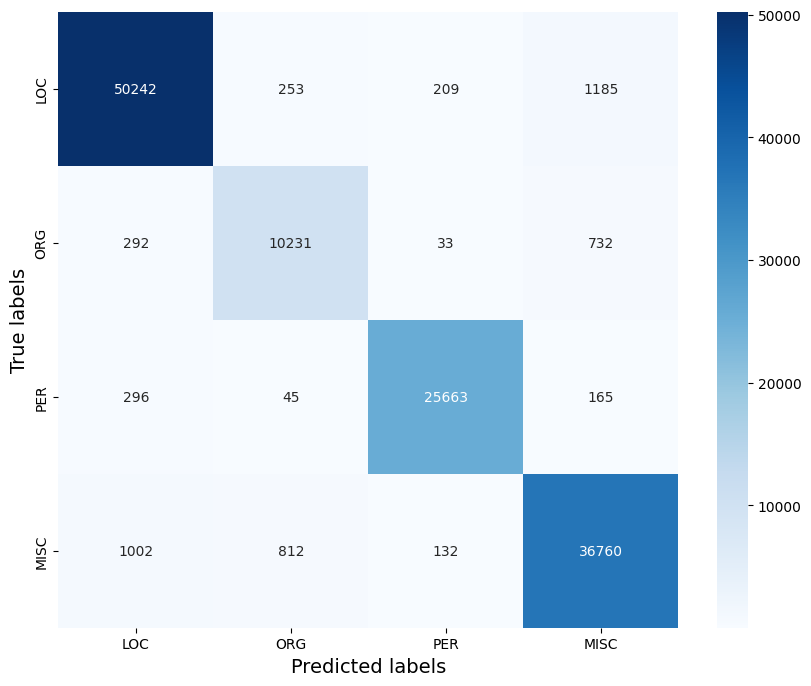

In [ ]:
# Map labels to their new aggregated positions
def aggregate_positions(label):
    if label in ['I-LOC', 'B-LOC']:
        return 0
    elif label in ['I-ORG', 'B-ORG']:
        return 1
    elif label in ['I-PER', 'B-PER']:
        return 2
    elif label in ['I-MISC', 'B-MISC']:
        return 3
    else:
        return -1  # For 'O'

# Aggregate the confusion matrix
num_folds = len(fine_tuned_camel_ner_model.confusion_matrices)
matrix_size = fine_tuned_camel_ner_model.confusion_matrices[0].shape
sum_cm = np.zeros(matrix_size)

for cm in fine_tuned_camel_ner_model.confusion_matrices:
    sum_cm += cm

# Create a new CM based on merged labels
new_cm_size = 4  # [LOC, ORG, PER, MISC]
new_cm = np.zeros((new_cm_size, new_cm_size))
labels = fine_tuned_camel_ner_model.custom_labels

for i, row_label in enumerate(labels):
    for j, col_label in enumerate(labels):
        new_i = aggregate_positions(row_label)
        new_j = aggregate_positions(col_label)
        if new_i != -1 and new_j != -1:  # Exclude the 'O' label
            new_cm[new_i][new_j] += sum_cm[i][j]

# Plotting the heatmap
new_labels = ['LOC', 'ORG', 'PER', 'MISC']
plt.figure(figsize=(10, 8))
min_val, max_val = new_cm.min(), new_cm.max()
sns.heatmap(new_cm, annot=True, fmt='.5g', cmap='Blues', xticklabels=new_labels, yticklabels=new_labels, vmin=min_val, vmax=max_val)
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.savefig("Camelheatmap.png")
plt.show()

In [ ]:
from google.colab import files
files.download("Camelheatmap.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#GigaBERT
model_name = "ychenNLP/arabic-ner-ace"
data = golden_Standard.copy()
random_seed = 101
data_size = 'full'
fine_tuned_ner_model = FineTunedNERModel(model_name, data, random_seed, data_size)
fine_tuned_ner_model.train_model()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ychenNLP/arabic-ner-ace and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([15, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([15]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We start now the fold 0!!




  0%|          | 0/9 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/4 [00:00<?, ?ba/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.165100,0.132114,0.691808,0.547188,0.611058,0.963597
2,0.103400,0.128745,0.648422,0.643032,0.645716,0.963999


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.165100,0.132114,0.691808,0.547188,0.611058,0.963597
2,0.103400,0.128745,0.648422,0.643032,0.645716,0.963999
3,0.082500,0.133600,0.680702,0.616626,0.647081,0.965497
4,0.068900,0.140278,0.645716,0.643032,0.644371,0.963950
5,0.059800,0.141649,0.642325,0.653790,0.648007,0.963938


{'LOC': {'precision': 0.7396021699819169, 'recall': 0.7436363636363637, 'f1': 0.741613780598368, 'number': 1650}, 'MISC': {'precision': 0.5952941176470589, 'recall': 0.5651526433358154, 'f1': 0.5798319327731092, 'number': 1343}, 'ORG': {'precision': 0.39274924471299094, 'recall': 0.3812316715542522, 'f1': 0.3869047619047619, 'number': 341}, 'PER': {'precision': 0.649810366624526, 'recall': 0.6798941798941799, 'f1': 0.6645119586296058, 'number': 756}, 'overall_precision': 0.6484220907297831, 'overall_recall': 0.6430317848410758, 'overall_f1': 0.6457156886815615, 'overall_accuracy': 0.9639991721148813}
We start now the fold 1!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.097100,0.095644,0.672866,0.727882,0.699294,0.970454
2,0.075200,0.095589,0.682570,0.734331,0.707505,0.971223
3,0.060200,0.099239,0.711453,0.703379,0.707393,0.972055
4,0.048700,0.104982,0.686441,0.731235,0.708130,0.971620
5,0.041700,0.107866,0.695510,0.711117,0.703227,0.971583


{'LOC': {'precision': 0.7230583985550872, 'recall': 0.8369337979094077, 'f1': 0.7758397932816538, 'number': 1435}, 'MISC': {'precision': 0.6390820584144645, 'recall': 0.6708029197080292, 'f1': 0.6545584045584045, 'number': 1370}, 'ORG': {'precision': 0.49859154929577465, 'recall': 0.5086206896551724, 'f1': 0.5035561877667141, 'number': 348}, 'PER': {'precision': 0.7670850767085077, 'recall': 0.7596685082872928, 'f1': 0.7633587786259541, 'number': 724}, 'overall_precision': 0.6825701270678495, 'overall_recall': 0.7343306680423007, 'overall_f1': 0.7075049701789264, 'overall_accuracy': 0.9712232002085636}
We start now the fold 2!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.075400,0.065722,0.789122,0.774381,0.781682,0.978104
2,0.057000,0.065475,0.780733,0.790393,0.785533,0.978528
3,0.043500,0.069034,0.778975,0.789180,0.784044,0.978702
4,0.034900,0.071843,0.773405,0.805677,0.789211,0.978840
5,0.028000,0.074908,0.769159,0.801067,0.784789,0.978478


{'LOC': {'precision': 0.8175099488345651, 'recall': 0.8942786069651741, 'f1': 0.8541728541728542, 'number': 1608}, 'MISC': {'precision': 0.7350037965072134, 'recall': 0.7250936329588015, 'f1': 0.7300150829562594, 'number': 1335}, 'ORG': {'precision': 0.6962025316455697, 'recall': 0.5759162303664922, 'f1': 0.6303724928366763, 'number': 382}, 'PER': {'precision': 0.8092189500640204, 'recall': 0.7929736511919699, 'f1': 0.8010139416983523, 'number': 797}, 'overall_precision': 0.7807332854061826, 'overall_recall': 0.7903930131004366, 'overall_f1': 0.7855334538878842, 'overall_accuracy': 0.9785278751075477}
We start now the fold 3!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.056100,0.051377,0.791086,0.868033,0.827775,0.983109
2,0.041700,0.053230,0.803770,0.850546,0.826497,0.983614
3,0.032100,0.056953,0.783321,0.875137,0.826687,0.982954
4,0.024500,0.058728,0.802104,0.874863,0.836905,0.983977
5,0.019600,0.061747,0.804989,0.872951,0.837593,0.983990


{'LOC': {'precision': 0.8202702702702702, 'recall': 0.9039463886820551, 'f1': 0.8600779312787814, 'number': 1343}, 'MISC': {'precision': 0.7640449438202247, 'recall': 0.8486739469578783, 'f1': 0.804138950480414, 'number': 1282}, 'ORG': {'precision': 0.7193877551020408, 'recall': 0.7704918032786885, 'f1': 0.7440633245382585, 'number': 366}, 'PER': {'precision': 0.8236111111111111, 'recall': 0.8863976083707026, 'f1': 0.8538516918646508, 'number': 669}, 'overall_precision': 0.791085657370518, 'overall_recall': 0.8680327868852459, 'overall_f1': 0.827774882751433, 'overall_accuracy': 0.9831094198959385}
We start now the fold 4!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.050700,0.042645,0.826154,0.875543,0.850132,0.986098
2,0.036900,0.045914,0.816138,0.887772,0.850449,0.985997
3,0.026900,0.049246,0.825876,0.877717,0.851008,0.986098
4,0.020400,0.051492,0.825623,0.882609,0.853165,0.986299
5,0.016100,0.053188,0.822830,0.883424,0.852051,0.986199


{'LOC': {'precision': 0.8397965670692944, 'recall': 0.930937279774489, 'f1': 0.8830213903743316, 'number': 1419}, 'MISC': {'precision': 0.809220985691574, 'recall': 0.8289902280130294, 'f1': 0.8189863234111022, 'number': 1228}, 'ORG': {'precision': 0.7485549132947977, 'recall': 0.7640117994100295, 'f1': 0.7562043795620438, 'number': 339}, 'PER': {'precision': 0.8630705394190872, 'recall': 0.899135446685879, 'f1': 0.8807339449541285, 'number': 694}, 'overall_precision': 0.8261538461538461, 'overall_recall': 0.8755434782608695, 'overall_f1': 0.8501319261213719, 'overall_accuracy': 0.9860980059130654}


In [ ]:
results_fine_tune_df = fine_tuned_ner_model.evaluate()

In [ ]:
results_fine_tune_df

0            1            2  \
LOC               precision     0.739602     0.723058     0.817510   
                  recall        0.743636     0.836934     0.894279   
                  f1            0.741614     0.775840     0.854173   
                  number     1650.000000  1435.000000  1608.000000   
MISC              precision     0.595294     0.639082     0.735004   
                  recall        0.565153     0.670803     0.725094   
                  f1            0.579832     0.654558     0.730015   
                  number     1343.000000  1370.000000  1335.000000   
ORG               precision     0.392749     0.498592     0.696203   
                  recall        0.381232     0.508621     0.575916   
                  f1            0.386905     0.503556     0.630372   
                  number      341.000000   348.000000   382.000000   
PER               precision     0.649810     0.767085     0.809219   
                  recall        0.679894     0.759669     0.792974   
                  f1            0.664512     0.763359     0.801014   
                  number      756.000000   724.000000   797.000000   
overall_precision               0.648422     0.682570     0.780733   
overall_recall                  0.643032     0.734331     0.790393   
overall_f1                      0.645716     0.707505     0.785533   
overall_accuracy                0.963999     0.971223     0.978528   

                                       3            4         mean         std  
LOC               precision     0.820270     0.839797     0.788047    0.047233  
                  recall        0.903946     0.930937     0.861946    0.066621  
                  f1            0.860078     0.883021     0.822945    0.054400  
                  number     1343.000000  1419.000000  1491.000000  117.638429  
MISC              precision     0.764045     0.809221     0.708529    0.079457  
                  recall        0.848674     0.828990     0.727743    0.104461  
                  f1            0.804139     0.818986     0.717506    0.090417  
                  number     1282.000000  1228.000000  1311.600000   50.614622  
ORG               precision     0.719388     0.748555     0.611097    0.140141  
                  recall        0.770492     0.764012     0.600054    0.150171  
                  f1            0.744063     0.756204     0.604220    0.141914  
                  number      366.000000   339.000000   355.200000   16.436545  
PER               precision     0.823611     0.863071     0.782559    0.073130  
                  recall        0.886398     0.899135     0.803614    0.081644  
                  f1            0.853852     0.880734     0.792694    0.075963  
                  number      669.000000   694.000000   728.000000   45.161931  
overall_precision               0.791086     0.826154     0.745793    0.068130  
overall_recall                  0.868033     0.875543     0.782266    0.086956  
overall_f1                      0.827775     0.850132     0.763332    0.076329  
overall_accuracy                0.983109     0.986098     0.976592    0.008050

In [ ]:
# #MaraBERT

# model_name = "ahmedoumar/my_ner_MARBERTv2"
# data = golden_Standard.copy()
# random_seed = 101
# data_size = 'full'
# fine_tuned_mar2_ner_model = FineTunedNERModel(model_name, data, random_seed, data_size)
# fine_tuned_mar2_ner_model.train_model()
# results_fine_tune_mar_df2 = fine_tuned_mar2_ner_model.evaluate()

In [ ]:
# results_fine_tune_mar_df2

In [ ]:
# #temp test mar
# model_name = "UBC-NLP/MARBERT"
# data = golden_Standard.iloc[:100]
# random_seed = 101
# data_size = 'full'
# fine_tuned_mar_ner_model = FineTunedNERModel(model_name, data, random_seed, data_size, use_mlm_head=True)
# fine_tuned_mar_ner_model.train_model()
# results_fine_tune_mar_df = fine_tuned_mar_ner_model.evaluate()

In [ ]:
#MaraBERT
model_name = "UBC-NLP/MARBERT"
data = golden_Standard.copy()
random_seed = 101
data_size = 'full'
fine_tuned_mar_ner_model = FineTunedNERModel(model_name, data, random_seed, data_size, use_mlm_head=True)
fine_tuned_mar_ner_model.train_model()
results_fine_tune_mar_df = fine_tuned_mar_ner_model.evaluate()


Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

We start now the fold 0!!




  0%|          | 0/9 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/4 [00:00<?, ?ba/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.189900,0.137011,0.683548,0.562069,0.616885,0.961594
2,0.105100,0.132694,0.648363,0.667109,0.657602,0.963218
3,0.077600,0.138038,0.663393,0.662865,0.663129,0.963918
4,0.060500,0.149763,0.650447,0.655968,0.653196,0.963078
5,0.048000,0.158640,0.640531,0.678249,0.658851,0.962686


{'LOC': {'precision': 0.7316313823163139, 'recall': 0.7755775577557755, 'f1': 0.7529637936558795, 'number': 1515}, 'MISC': {'precision': 0.6126704089815558, 'recall': 0.6034755134281201, 'f1': 0.6080382013529647, 'number': 1266}, 'ORG': {'precision': 0.3859060402684564, 'recall': 0.3516819571865443, 'f1': 0.368, 'number': 327}, 'PER': {'precision': 0.6332417582417582, 'recall': 0.6963746223564955, 'f1': 0.6633093525179856, 'number': 662}, 'overall_precision': 0.6483629801495231, 'overall_recall': 0.6671087533156499, 'overall_f1': 0.6576023009543731, 'overall_accuracy': 0.9632181011187186}
We start now the fold 1!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.097500,0.097553,0.675227,0.747492,0.709524,0.969686
2,0.071000,0.093531,0.706395,0.744983,0.725176,0.971602
3,0.052400,0.100673,0.703791,0.744983,0.723802,0.971931
4,0.037500,0.113960,0.694753,0.749164,0.720933,0.971130
5,0.028500,0.119602,0.696579,0.737737,0.716567,0.971073


{'LOC': {'precision': 0.7264091196960102, 'recall': 0.8663141993957704, 'f1': 0.7902170168790906, 'number': 1324}, 'MISC': {'precision': 0.6687647521636507, 'recall': 0.6543494996150885, 'f1': 0.66147859922179, 'number': 1299}, 'ORG': {'precision': 0.5629139072847682, 'recall': 0.5167173252279635, 'f1': 0.5388272583201268, 'number': 329}, 'PER': {'precision': 0.8006329113924051, 'recall': 0.7955974842767296, 'f1': 0.7981072555205048, 'number': 636}, 'overall_precision': 0.7063953488372093, 'overall_recall': 0.7449832775919732, 'overall_f1': 0.7251763429191537, 'overall_accuracy': 0.9716017959790659}
We start now the fold 2!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.071300,0.061286,0.793910,0.825916,0.809597,0.979502
2,0.050100,0.062660,0.813284,0.798168,0.805655,0.979660
3,0.033700,0.065039,0.800152,0.825916,0.812830,0.980019
4,0.023300,0.071227,0.806968,0.830628,0.818627,0.980522
5,0.016100,0.079413,0.802714,0.836126,0.819079,0.980378


{'LOC': {'precision': 0.8229229836264402, 'recall': 0.9144204851752021, 'f1': 0.866262368337057, 'number': 1484}, 'MISC': {'precision': 0.7534456355283308, 'recall': 0.7797147385103012, 'f1': 0.7663551401869159, 'number': 1262}, 'ORG': {'precision': 0.712166172106825, 'recall': 0.6629834254143646, 'f1': 0.6866952789699571, 'number': 362}, 'PER': {'precision': 0.841642228739003, 'recall': 0.8061797752808989, 'f1': 0.8235294117647058, 'number': 712}, 'overall_precision': 0.7939104177151485, 'overall_recall': 0.8259162303664922, 'overall_f1': 0.8095971259943546, 'overall_accuracy': 0.9795018386577798}
We start now the fold 3!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.059100,0.058164,0.757161,0.897020,0.821178,0.980995
2,0.040900,0.054915,0.797220,0.863086,0.828847,0.982481
3,0.027200,0.063945,0.784673,0.873119,0.826536,0.981975
4,0.017600,0.070697,0.779393,0.886102,0.829329,0.982198
5,0.011600,0.075449,0.790586,0.872234,0.829405,0.982481


{'LOC': {'precision': 0.8245227606461086, 'recall': 0.9056451612903226, 'f1': 0.8631821675634128, 'number': 1240}, 'MISC': {'precision': 0.776661514683153, 'recall': 0.8292079207920792, 'f1': 0.8020750199521149, 'number': 1212}, 'ORG': {'precision': 0.723943661971831, 'recall': 0.7626112759643917, 'f1': 0.7427745664739883, 'number': 337}, 'PER': {'precision': 0.8206686930091185, 'recall': 0.9, 'f1': 0.8585055643879175, 'number': 600}, 'overall_precision': 0.7972199509403107, 'overall_recall': 0.8630864561817645, 'overall_f1': 0.8288466987815245, 'overall_accuracy': 0.9824806454968275}
We start now the fold 4!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.042200,0.036865,0.851447,0.918139,0.883536,0.988575
2,0.027400,0.037027,0.856441,0.924028,0.888952,0.989516
3,0.018200,0.040992,0.861581,0.914605,0.887302,0.989328
4,0.011300,0.044587,0.860929,0.927856,0.893141,0.989719
5,0.007100,0.047976,0.863274,0.924028,0.892618,0.989748


{'LOC': {'precision': 0.8473541383989145, 'recall': 0.9689681923972071, 'f1': 0.9040897575099529, 'number': 1289}, 'MISC': {'precision': 0.8407079646017699, 'recall': 0.8870967741935484, 'f1': 0.8632796365138373, 'number': 1178}, 'ORG': {'precision': 0.8509933774834437, 'recall': 0.8006230529595015, 'f1': 0.8250401284109149, 'number': 321}, 'PER': {'precision': 0.8818040435458787, 'recall': 0.9325657894736842, 'f1': 0.9064748201438849, 'number': 608}, 'overall_precision': 0.8514472965592572, 'overall_recall': 0.9181389870435807, 'overall_f1': 0.8835364125814678, 'overall_accuracy': 0.988574821164818}


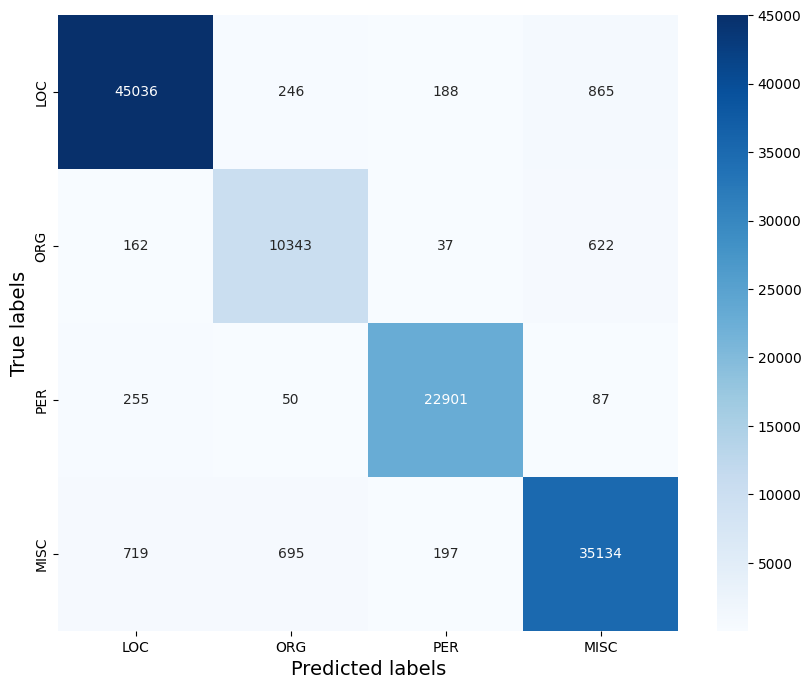

In [ ]:


# Map labels to their new aggregated positions
def aggregate_positions(label):
    if label in ['I-LOC', 'B-LOC']:
        return 0
    elif label in ['I-ORG', 'B-ORG']:
        return 1
    elif label in ['I-PER', 'B-PER']:
        return 2
    elif label in ['I-MISC', 'B-MISC']:
        return 3
    else:
        return -1  # For 'O'

# Aggregate the confusion matrix
num_folds = len(fine_tuned_mar_ner_model.confusion_matrices)
matrix_size = fine_tuned_mar_ner_model.confusion_matrices[0].shape
sum_cm = np.zeros(matrix_size)

for cm in fine_tuned_mar_ner_model.confusion_matrices:
    sum_cm += cm

# Create a new CM based on merged labels
new_cm_size = 4  # [LOC, ORG, PER, MISC]
new_cm = np.zeros((new_cm_size, new_cm_size))
labels = fine_tuned_mar_ner_model.custom_labels

for i, row_label in enumerate(labels):
    for j, col_label in enumerate(labels):
        new_i = aggregate_positions(row_label)
        new_j = aggregate_positions(col_label)
        if new_i != -1 and new_j != -1:  # Exclude the 'O' label
            new_cm[new_i][new_j] += sum_cm[i][j]

# Plotting the heatmap
new_labels = ['LOC', 'ORG', 'PER', 'MISC']
plt.figure(figsize=(10, 8))
min_val, max_val = new_cm.min(), new_cm.max()
sns.heatmap(new_cm, annot=True, fmt='.5g', cmap='Blues', xticklabels=new_labels, yticklabels=new_labels, vmin=min_val, vmax=max_val)
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.savefig("MARBERTheatmap.png")
plt.show()


In [ ]:
files.download("MARBERTheatmap.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
results_fine_tune_mar_df

0            1            2  \
LOC               precision     0.731631     0.726409     0.822923   
                  recall        0.775578     0.866314     0.914420   
                  f1            0.752964     0.790217     0.866262   
                  number     1515.000000  1324.000000  1484.000000   
MISC              precision     0.612670     0.668765     0.753446   
                  recall        0.603476     0.654349     0.779715   
                  f1            0.608038     0.661479     0.766355   
                  number     1266.000000  1299.000000  1262.000000   
ORG               precision     0.385906     0.562914     0.712166   
                  recall        0.351682     0.516717     0.662983   
                  f1            0.368000     0.538827     0.686695   
                  number      327.000000   329.000000   362.000000   
PER               precision     0.633242     0.800633     0.841642   
                  recall        0.696375     0.795597     0.806180   
                  f1            0.663309     0.798107     0.823529   
                  number      662.000000   636.000000   712.000000   
overall_precision               0.648363     0.706395     0.793910   
overall_recall                  0.667109     0.744983     0.825916   
overall_f1                      0.657602     0.725176     0.809597   
overall_accuracy                0.963218     0.971602     0.979502   

                                       3            4         mean         std  
LOC               precision     0.824523     0.847354     0.790568    0.051018  
                  recall        0.905645     0.968968     0.886185    0.064277  
                  f1            0.863182     0.904090     0.835343    0.055281  
                  number     1240.000000  1289.000000  1370.400000  109.176188  
MISC              precision     0.776662     0.840708     0.730450    0.080620  
                  recall        0.829208     0.887097     0.750769    0.106365  
                  f1            0.802075     0.863280     0.740245    0.093086  
                  number     1212.000000  1178.000000  1243.400000   42.921323  
ORG               precision     0.723944     0.850993     0.647185    0.159387  
                  recall        0.762611     0.800623     0.618923    0.165811  
                  f1            0.742775     0.825040     0.632267    0.161805  
                  number      337.000000   321.000000   335.200000   14.344337  
PER               precision     0.820669     0.881804     0.795598    0.085516  
                  recall        0.900000     0.932566     0.826144    0.083609  
                  f1            0.858506     0.906475     0.809985    0.081857  
                  number      600.000000   608.000000   643.600000   40.603448  
overall_precision               0.797220     0.851447     0.759467    0.072433  
overall_recall                  0.863086     0.918139     0.803847    0.088568  
overall_f1                      0.828847     0.883536     0.780952    0.079955  
overall_accuracy                0.982481     0.988575     0.977075    0.008824

In [ ]:
# temp_df = fine_tuned_mar_ner_model.predictions_df
# mismatched = temp_df[temp_df['ground_truth'] != temp_df['predicted_entity']]
# # Extract unique IDs from the mismatched DataFrame
# unique_mismatched_ids = mismatched['id'].unique()

# # Create a mask for the original DataFrame
# mask = golden_Standard['id'].isin(unique_mismatched_ids)

# # Extract corresponding 'text' values from golden_Standart using the unique IDs
# temp = golden_Standard.copy()
# text_values = temp[temp['id'].isin(unique_mismatched_ids)][['id', 'text']].drop_duplicates()

# # Merge the text values to the mismatched DataFrame based on the 'id'
# mismatched_with_text = pd.merge(mismatched, text_values, on='id', how='left')

In [ ]:
# mismatched_with_text

NameError: ignored

In [ ]:
#  mismatched_with_text.to_csv('DisagreementForReview')

In [ ]:
#AraBERT
model_name = "aubmindlab/bert-base-arabertv02"
#"aubmindlab/bert-base-arabertv2"
# "abdusah/arabert-ner"
data = golden_Standard.copy()
random_seed = 101
data_size = 'full'
fine_tuned_ara_ner_model  = FineTunedNERModel(model_name, data, random_seed, data_size, use_mlm_head=True)
fine_tuned_ara_ner_model.train_model()
results_fine_tune_ara_df = fine_tuned_ara_ner_model.evaluate()

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

We start now the fold 0!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.150200,0.120394,0.691832,0.584270,0.633517,0.967169
2,0.094700,0.119109,0.654616,0.657695,0.656152,0.966645
3,0.076900,0.121423,0.677437,0.646459,0.661586,0.967991
4,0.065900,0.126942,0.682330,0.633656,0.657093,0.968265
5,0.057300,0.127479,0.667112,0.651947,0.659442,0.967617


{'LOC': {'precision': 0.7644736842105263, 'recall': 0.7685185185185185, 'f1': 0.7664907651715039, 'number': 1512}, 'MISC': {'precision': 0.6071428571428571, 'recall': 0.5740598618572524, 'f1': 0.5901380670611439, 'number': 1303}, 'ORG': {'precision': 0.4074074074074074, 'recall': 0.39520958083832336, 'f1': 0.40121580547112456, 'number': 334}, 'PER': {'precision': 0.6176853055916776, 'recall': 0.700589970501475, 'f1': 0.6565307532826538, 'number': 678}, 'overall_precision': 0.6546163849154747, 'overall_recall': 0.6576953227070813, 'overall_f1': 0.6561522419186654, 'overall_accuracy': 0.966645493155974}
We start now the fold 1!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.090500,0.088509,0.683312,0.742731,0.711783,0.972878
2,0.071800,0.086351,0.714523,0.713930,0.714226,0.973794
3,0.058400,0.090716,0.723979,0.697314,0.710396,0.973960
4,0.048000,0.094271,0.704093,0.724176,0.713993,0.973451
5,0.041800,0.097296,0.708288,0.714760,0.711509,0.973565


{'LOC': {'precision': 0.7614285714285715, 'recall': 0.8125, 'f1': 0.7861356932153393, 'number': 1312}, 'MISC': {'precision': 0.6783103168155971, 'recall': 0.6349809885931559, 'f1': 0.6559308719560094, 'number': 1315}, 'ORG': {'precision': 0.49271137026239065, 'recall': 0.5059880239520959, 'f1': 0.49926144756277696, 'number': 334}, 'PER': {'precision': 0.8012618296529969, 'recall': 0.7815384615384615, 'f1': 0.7912772585669783, 'number': 650}, 'overall_precision': 0.7145232815964523, 'overall_recall': 0.7139296593741346, 'overall_f1': 0.714226347139493, 'overall_accuracy': 0.9737943492475416}
We start now the fold 2!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.070600,0.064824,0.792746,0.749613,0.770577,0.978795
2,0.055100,0.066099,0.753137,0.804796,0.778110,0.978347
3,0.043000,0.066669,0.764177,0.788809,0.776297,0.978539
4,0.034600,0.069225,0.763191,0.787004,0.774914,0.978565
5,0.029300,0.072075,0.765500,0.789582,0.777355,0.978616


{'LOC': {'precision': 0.8302250803858521, 'recall': 0.8658618376928237, 'f1': 0.8476690741956665, 'number': 1491}, 'MISC': {'precision': 0.7736185383244206, 'recall': 0.6749611197511665, 'f1': 0.7209302325581396, 'number': 1286}, 'ORG': {'precision': 0.6151419558359621, 'recall': 0.5386740331491713, 'f1': 0.5743740795287187, 'number': 362}, 'PER': {'precision': 0.8216939078751857, 'recall': 0.7483085250338295, 'f1': 0.78328611898017, 'number': 739}, 'overall_precision': 0.7927461139896373, 'overall_recall': 0.7496132026817948, 'overall_f1': 0.7705765407554673, 'overall_accuracy': 0.978794971159626}
We start now the fold 3!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.060600,0.060950,0.748654,0.848300,0.795368,0.980051
2,0.047000,0.060986,0.770011,0.816332,0.792495,0.980526
3,0.036600,0.067517,0.736020,0.849172,0.788558,0.979389
4,0.028400,0.070354,0.759880,0.810230,0.784248,0.979958
5,0.024200,0.072031,0.762510,0.819239,0.789857,0.980328


{'LOC': {'precision': 0.7872044506258693, 'recall': 0.9143780290791599, 'f1': 0.8460388639760836, 'number': 1238}, 'MISC': {'precision': 0.7277486910994765, 'recall': 0.7884927066450568, 'f1': 0.7569039284325166, 'number': 1234}, 'ORG': {'precision': 0.6809651474530831, 'recall': 0.7134831460674157, 'f1': 0.6968449931412894, 'number': 356}, 'PER': {'precision': 0.7456724367509987, 'recall': 0.9135399673735726, 'f1': 0.8211143695014663, 'number': 613}, 'overall_precision': 0.748653500897666, 'overall_recall': 0.8482999128160419, 'overall_f1': 0.7953678474114443, 'overall_accuracy': 0.9800505017120344}
We start now the fold 4!!




  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.054600,0.047529,0.813465,0.809690,0.811573,0.983974
2,0.040900,0.048525,0.797694,0.843052,0.819746,0.984168
3,0.031200,0.051614,0.802567,0.852625,0.826839,0.984554
4,0.024400,0.054379,0.805256,0.844502,0.824412,0.984593
5,0.019800,0.056499,0.802599,0.842182,0.821914,0.984400


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.054600,0.047529,0.813465,0.809690,0.811573,0.983974
2,0.040900,0.048525,0.797694,0.843052,0.819746,0.984168
3,0.031200,0.051614,0.802567,0.852625,0.826839,0.984554
4,0.024400,0.054379,0.805256,0.844502,0.824412,0.984593
5,0.019800,0.056499,0.802599,0.842182,0.821914,0.984400


{'LOC': {'precision': 0.8276108726752504, 'recall': 0.8927469135802469, 'f1': 0.8589458054936896, 'number': 1296}, 'MISC': {'precision': 0.7912885662431942, 'recall': 0.7309304274937133, 'f1': 0.7599128540305011, 'number': 1193}, 'ORG': {'precision': 0.6982248520710059, 'recall': 0.7239263803680982, 'f1': 0.710843373493976, 'number': 326}, 'PER': {'precision': 0.8870151770657673, 'recall': 0.8322784810126582, 'f1': 0.8587755102040816, 'number': 632}, 'overall_precision': 0.8134654619644418, 'overall_recall': 0.8096895851465042, 'overall_f1': 0.8115731317243385, 'overall_accuracy': 0.9839744415530879}


In [ ]:
results_fine_tune_ara_df

0            1            2  \
LOC               precision     0.764474     0.761429     0.830225   
                  recall        0.768519     0.812500     0.865862   
                  f1            0.766491     0.786136     0.847669   
                  number     1512.000000  1312.000000  1491.000000   
MISC              precision     0.607143     0.678310     0.773619   
                  recall        0.574060     0.634981     0.674961   
                  f1            0.590138     0.655931     0.720930   
                  number     1303.000000  1315.000000  1286.000000   
ORG               precision     0.407407     0.492711     0.615142   
                  recall        0.395210     0.505988     0.538674   
                  f1            0.401216     0.499261     0.574374   
                  number      334.000000   334.000000   362.000000   
PER               precision     0.617685     0.801262     0.821694   
                  recall        0.700590     0.781538     0.748309   
                  f1            0.656531     0.791277     0.783286   
                  number      678.000000   650.000000   739.000000   
overall_precision               0.654616     0.714523     0.792746   
overall_recall                  0.657695     0.713930     0.749613   
overall_f1                      0.656152     0.714226     0.770577   
overall_accuracy                0.966645     0.973794     0.978795   

                                       3            4         mean         std  
LOC               precision     0.787204     0.827611     0.794189    0.029734  
                  recall        0.914378     0.892747     0.850801    0.053415  
                  f1            0.846039     0.858946     0.821056    0.037322  
                  number     1238.000000  1296.000000  1369.800000  110.515881  
MISC              precision     0.727749     0.791289     0.715622    0.066927  
                  recall        0.788493     0.730930     0.680685    0.074347  
                  f1            0.756904     0.759913     0.696763    0.065154  
                  number     1234.000000  1193.000000  1266.200000   45.875484  
ORG               precision     0.680965     0.698225     0.578890    0.112078  
                  recall        0.713483     0.723926     0.575456    0.126303  
                  f1            0.696845     0.710843     0.576508    0.117666  
                  number      356.000000   326.000000   342.400000   13.994285  
PER               precision     0.745672     0.887015     0.774666    0.090581  
                  recall        0.913540     0.832278     0.795251    0.073097  
                  f1            0.821114     0.858776     0.782197    0.068197  
                  number      613.000000   632.000000   662.400000   43.884394  
overall_precision               0.748654     0.813465     0.744801    0.056707  
overall_recall                  0.848300     0.809690     0.755846    0.067641  
overall_f1                      0.795368     0.811573     0.749579    0.057200  
overall_accuracy                0.980051     0.983974     0.976652    0.005968

In [ ]:
#NewLLMBert
model_name = "inception-mbzuai/jais-13b"

data = golden_Standard.copy()
random_seed = 101
data_size = 'full'
fine_tuned_llm_ner_model  = FineTunedNERModel(model_name, data, random_seed, data_size, use_mlm_head=True)
fine_tuned_llm_ner_model.train_model()
results_fine_tune_llm_df = fine_tuned_llm_ner_model.evaluate()

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

Loading inception-mbzuai/jais-13b requires to execute some code in that repo, you can inspect the content of the repository at https://hf.co/inception-mbzuai/jais-13b. You can dismiss this prompt by passing `trust_remote_code=True`.
Do you accept? [y/N] y


A new version of the following files was downloaded from https://huggingface.co/inception-mbzuai/jais-13b:
- configuration_jais.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading inception-mbzuai/jais-13b requires to execute some code in that repo, you can inspect the content of the repository at https://hf.co/inception-mbzuai/jais-13b. You can dismiss this prompt by passing `trust_remote_code=True`.
Do you accept? [y/N] y


A new version of the following files was downloaded from https://huggingface.co/inception-mbzuai/jais-13b:
- modeling_jais.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [ ]:
results_fine_tune_ara_df

# 4. Load Pretrained Model for Fine-Tuning - old guy code

---





In [ ]:
!pip install --upgrade camel_tools


In [ ]:
golden_Standard[golden_Standard['id']==40265220]

,id,text,our-Interval,word,BIOES,word_interval,BIO,BIO_num
21,40265220,هلا صباح هلا يا أحمد,"(0, 3)",هلا,O,"(0, 3)",O,0
22,40265220,هلا صباح هلا يا أحمد,"(4, 8)",صباح,O,"(0, 4)",O,0
23,40265220,هلا صباح هلا يا أحمد,"(9, 12)",هلا,O,"(0, 3)",O,0
24,40265220,هلا صباح هلا يا أحمد,"(13, 15)",يا,O,"(0, 2)",O,0
25,40265220,هلا صباح هلا يا أحمد,"(16, 20)",أحمد,S-PER,"(0, 4)",B-PER,2


In [ ]:
import string
def remove_punctuation(text):
  additional_punctuation = "،؛؟"
  all_punctuation = string.punctuation + additional_punctuation
  return text.translate(str.maketrans('', '', all_punctuation))

In [ ]:
golden_Standard['text'] = golden_Standard['text'].apply(remove_punctuation)
sentence = golden_Standard[golden_Standard['id']==40265218]['text'][0]
len(sentence)

94

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-ner")
golden_Standard[golden_Standard['id']==40265218]
string_sentence = golden_Standard[golden_Standard['id']==40265218]['text'][0]
sentence = tokenizer(golden_Standard[golden_Standard['id']==40265218]['text'][0])
sentence

{'input_ids': [2, 9388, 1955, 24404, 4105, 12259, 8231, 4254, 5398, 1045, 4045, 2008, 1912, 5415, 387, 1010, 8877, 1973, 7444, 1013, 2217, 9105, 2902, 14925, 2600, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# Decode the input_ids
decoded_text = tokenizer.decode(sentence['input_ids'], skip_special_tokens=True)

# Tokenize using simple whitespace-based split
whitespace_tokens = decoded_text.split()

# Print and compare
print("OG               :",  string_sentence)
print("BERT Tokenization:", decoded_text)
print("Whitespace Tokens:", whitespace_tokens)

OG               : مرحبا عن اللد والرملة والعمل السياسي المركب والمعقد في مناطق ال48 مع ضيفي اليوم سامي أبو شحادة
BERT Tokenization: مرحبا عن اللد والرملة والعمل السياسي المركب والمعقد في مناطق ال48 مع ضيفي اليوم سامي أبو شحادة
Whitespace Tokens: ['مرحبا', 'عن', 'اللد', 'والرملة', 'والعمل', 'السياسي', 'المركب', 'والمعقد', 'في', 'مناطق', 'ال48', 'مع', 'ضيفي', 'اليوم', 'سامي', 'أبو', 'شحادة']


In [ ]:
from transformers import AutoTokenizer

def tokenize_and_align_labels(sentece_id,text, golden_standard, label_all_tokens=True):
    tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-ner")

    # Assuming text_id is the unique id of the sentence you want to process
    string_sentence = text
    tokenized_inputs = tokenizer(string_sentence, truncation=True, padding=True, max_length=512, return_tensors='pt')

    # Get the labels from golden_standard
    labels_for_sentence = golden_standard[golden_standard['id'] == sentece_id]['BIO_num'].tolist()



    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    label_ids = []
    # print(sentece_id)
    # print(len(labels_for_sentence))
    # print(len(string_sentence.split()))

    for word_idx in word_ids:
        # Special tokens have a word id that is None. We set the label to -100 so they are automatically
        # ignored in the loss function.
        if word_idx is None:
          label_ids.append(-100)
        elif word_idx >= len(labels_for_sentence):
          label_ids.append(-100)

        # We set the label for the first token of each word.
        elif word_idx != previous_word_idx:
            # print(f"word_idx: {word_idx}, len(labels_for_sentence): {len(labels_for_sentence)}")

            label_ids.append(labels_for_sentence[word_idx])
        # For the other tokens in a word, we set the label to either the current label or -100, depending on
        # the label_all_tokens flag.
        else:
            label_ids.append(labels_for_sentence[word_idx] if label_all_tokens else -100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs


In [ ]:
text_id = golden_Standard.copy()
text_id.drop_duplicates(subset=['text', 'id'], keep='first', inplace=True)
text_id.drop(columns=['our-Interval', 'word', 'BIOES', 'word_interval', 'BIO', 'BIO_num'], inplace=True)

all_input_ids = []
all_attention_masks = []
all_labels = []

for idx in text_id['id'].unique():  # Using text_id since it has unique ids
    row = text_id[text_id['id'] == idx]
    text = row['text'].iloc[0]  # Extracting the text for the specific id
    # print(text)
    output = tokenize_and_align_labels(idx, text, golden_Standard)

    all_input_ids.append(output['input_ids'])
    all_attention_masks.append(output['attention_mask'])
    all_labels.append(output['labels'])






In [ ]:
    df = pd.DataFrame({
    'id': all_input_ids,
    'attention_masks': all_attention_masks,
    'labels': all_labels,
})

In [ ]:
df

,id,attention_masks,labels
0,"[[tensor(2), tensor(9388), tensor(1955), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[-100, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[[tensor(2), tensor(9388), tensor(9105), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[-100, 0, 2, 0, 0, -100]"
2,"[[tensor(2), tensor(9106), tensor(2570), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[-100, 0, 0, 0, 0, 2, -100]"
3,"[[tensor(2), tensor(2807), tensor(2784), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[-100, 0, 0, 4, 0, 0, 0, 0, 0, 0, -100]"
4,"[[tensor(2), tensor(8096), tensor(2706), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[-100, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
2956,"[[tensor(2), tensor(24833), tensor(12265), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[-100, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ..."
2957,"[[tensor(2), tensor(1963), tensor(3897), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2958,"[[tensor(2), tensor(27721), tensor(14073), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2959,"[[tensor(2), tensor(5794), tensor(16214), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...","[-100, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ..."


In [ ]:
def split_dataframe_based_on_ids(df, test_ratio=0.2, random_seed=42):
    # Get unique IDs
    unique_ids = df['id'].unique()

    temp_df = df.copy()
    # temp_df = consolidate_labels(temp_df)
    # Determine the number of test IDs
    n_test = int(len(unique_ids) * test_ratio)

    # Randomly shuffle the unique IDs
    np.random.seed(random_seed)
    shuffled_ids = np.random.permutation(unique_ids)

    # Split IDs into test and train
    test_ids = shuffled_ids[:n_test]
    train_ids = shuffled_ids[n_test:]

    # Split the dataframe based on the test and train IDs
    test_df = temp_df[temp_df['id'].isin(test_ids)]
    train_df = temp_df[temp_df['id'].isin(train_ids)]

    return train_df, test_df

train_df , test_df = split_dataframe_based_on_ids(golden_Standard)


In [ ]:
print(len(test_df))
print(len(train_df))

17032
69052


In [ ]:
train_df

,id,text,our-Interval,word,BIOES,BIO,BIO_num
0,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,"(0, 5)",مرحبا,O,O,0
1,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,"(6, 8)",عن,O,O,0
2,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,"(9, 13)",اللد,S-LOC,B-LOC,1
3,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,"(14, 22)",والرملة،,S-LOC,B-LOC,1
4,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...,"(23, 29)",والعمل,O,O,0
...,...,...,...,...,...,...,...
103542,50510372,صحة وعافية. صحة وعافية هو محمد محمد أصلا قصة ب...,"(182, 187)",بنجرب,O,O,0
103543,50510372,صحة وعافية. صحة وعافية هو محمد محمد أصلا قصة ب...,"(188, 192)",طبخك,O,O,0
103544,50510372,صحة وعافية. صحة وعافية هو محمد محمد أصلا قصة ب...,"(193, 198)",وطبخه,O,O,0
103546,50510372,صحة وعافية. صحة وعافية هو محمد محمد أصلا قصة ب...,"(204, 211)",المعفشك,O,O,0


In [ ]:
def generate_labels_from_dataframe(df):
    """Generate grouped labels for unique ids in a dataframe."""
    labels = []
    for _, group in df.groupby('id'):
        labels.append(group['BIO_num'].tolist())
    return labels


In [ ]:
# def adjust_labels_for_offsets(original_sentences, offset_mappings, df):
#     new_labels = []

#     # Iterating over each sentence and its corresponding offset mapping
#     for sentence, offsets in zip(original_sentences, offset_mappings):

#         # Checking if the offsets are serialized
#         if len(offsets) % 2 == 0:
#             # Reconstructing the (start, end) pairs
#             offsets = [(offsets[i], offsets[i+1]) for i in range(0, len(offsets), 2)]

#         # Here, I'll gather all word intervals for this particular sentence from the dataframe
#         word_intervals = df[df['text'] == sentence]['word_interval'].tolist()

#         # This is to store labels for the current sentence
#         labels_for_current_sentence = []

#         # Now iterate over the tokens in the current sentence
#         for token_idx, (start, end) in enumerate(offsets):
#             # If the start character index of this token matches with the word's start index in our dataframe
#             for interval in word_intervals:
#                 if interval[0] == start:
#                     # Fetch the corresponding label
#                     label_for_current_word = df[(df['text'] == sentence) & (df['word_interval'] == interval)]['BIO'].iloc[0]
#                     labels_for_current_sentence.append(label_for_current_word)
#                     break
#             else:
#                 labels_for_current_sentence.append("X")  # For subwords

#         new_labels.append(labels_for_current_sentence)
#     return new_labels



# def adjust_labels_for_verification(encodings, df):
#     labels = adjust_labels_for_offsets(df['text'].tolist(), encodings['offset_mapping'], df)
#     encoded_labels = []
#     label_map = {"O": 0, "B-LOC": 1, "I-LOC": 2, "B-ORG": 3, "I-ORG": 4, "B-PER": 5, "I-PER": 6, "X": 7}
#     for doc_labels in labels:
#         encoded_labels.append([label_map[label] for label in doc_labels])
#     return encoded_labels


In [ ]:
def align_labels_with_tokens(tokenizer, dataframe):
    new_data = []
    for _, group in dataframe.groupby('id'):
        sentence = group['text'].iloc[0]
        labels = group['BIO_num'].tolist()
        id = group['id'].iloc[0]

        # Tokenize the sentence and get the offset mapping
        encoding = tokenizer.encode_plus(sentence, return_offsets_mapping=True)
        tokens = encoding['input_ids']
        offsets = encoding['offset_mapping']

        # Initialize aligned labels with special token -100
        aligned_labels = [-100] * len(tokens)

        # Iterate over the original labels and align them with the tokens
        label_index = 0
        for i, (start, end) in enumerate(offsets):
            if start == end:
                continue
            if label_index >= len(labels):
                break
            aligned_labels[i] = labels[label_index]
            label_index += 1

        new_data.append([id, sentence, tokens, aligned_labels])

    # Create a new DataFrame
    new_df = pd.DataFrame(new_data, columns=['id', 'text', 'tokens', 'labels'])

    return new_df




In [ ]:
# # Extract unique sentences for training data
# train_sentences = train_df.drop_duplicates(subset='id')['text'].tolist()

# # Extract unique sentences for testing data
# test_sentences = test_df.drop_duplicates(subset='id')['text'].tolist()

# train_labels = generate_labels_from_dataframe(train_df)
# test_labels = generate_labels_from_dataframe(test_df)

# assert len(train_labels) == len(train_sentences)
# assert len(test_labels) == len(test_sentences)


True


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.utils.data import DataLoader, TensorDataset
import torch

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-ner")
model = AutoModelForTokenClassification.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-ner")

# 1. Use the align_labels_with_tokens function to prepare data
train_df_aligned = align_labels_with_tokens(tokenizer,train_df)
test_df_aligned = align_labels_with_tokens(tokenizer,test_df)

# Extract unique sentences for training data
train_sentences = train_df_aligned.drop_duplicates(subset='id')['text'].tolist()

# Extract unique sentences for testing data
test_sentences = test_df_aligned.drop_duplicates(subset='id')['text'].tolist()

train_labels = generate_labels_from_dataframe(train_df_aligned)
test_labels = generate_labels_from_dataframe(test_df_aligned)

assert len(train_labels) == len(train_sentences)
assert len(test_labels) == len(test_sentences)

print(train_sentences)
print(train_labels)



# 2 Tokenize sentences
train_encodings = tokenizer(train_sentences, return_tensors='pt', padding=True, truncation=True)
test_encodings = tokenizer(test_sentences, return_tensors='pt', padding=True, truncation=True)

for i, encoding in enumerate(train_encodings['input_ids']):
    if encoding.shape[0] != len(train_labels[i]):
        print(f"Mismatch at index {i}: encoding length = {encoding.shape[0]}, label length = {len(train_labels[i])}")


# 3 Convert labels to tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# 4 Create TensorDatasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# 5 Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-da-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyError: ignored

In [ ]:
#FineTune the model:
import torch.optim as optim
from tqdm import tqdm

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Define the optimizer and criterion
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

def train(model, optimizer, criterion, train_loader):
    model.train()
    total_loss = 0
    for i, batch in enumerate(tqdm(train_loader)):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        print(f"Batch input_ids shape: {input_ids.shape}")
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
epochs = 3
for epoch in range(epochs):
    loss = train(model, optimizer, criterion, train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}')


  0%|          | 0/16 [00:00<?, ?it/s]

Batch input_ids shape: torch.Size([32])


ValueError: ignored

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted = torch.argmax(outputs.logits, dim=-1)
            total_correct += (predicted == labels).sum().item()
            total += labels.numel()
    return total_correct / total

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {accuracy * 100:.2f}%')



In [ ]:
#saving model:
model_save_path = "/content/drive/MyDrive/NER_model"
model.save_pretrained('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')


# 7.Evaluation and Inference

---




In [ ]:
#TEST CAMEL AND MARBERT:
samples = golden_Standard[['id', 'text']].drop_duplicates()
samples

,id,text
0,40265218,مرحبا عن اللد والرملة، والعمل السياسي المركب و...
17,40265219,مرحبا، سامي، صباح الخير
21,40265220,هلا صباح هلا يا أحمد
26,40265222,"الحمد لله والله تمام التمام, ماشية الأمور"
33,40265224,شوي والله فترة مضغوطة تعرف بالإضافة لكل الضغط ...
...,...,...
233024,62072373,جزء من الرواية وجزء من الهذا بتعرض بشكل دائم ل...
233039,62072403,أنا بالنسبة لإلي أي صورة لواحد مثلا بكاميرا بع...
233074,62072405,يعني أنا في كمان مثلا بعطيك موقف في كمان صور إ...
233113,62072410,هل أنا لما بصور مشروع عن العاملات بالطوب في ال...
